# Machine Learning con PySpark & MLflow Tracking

Questo notebook implementa **due modelli di machine learning distribuito** utilizzando PySpark MLlib, con tracking completo degli esperimenti tramite MLflow:

1. **ALS Recommendation System** - Sistema di raccomandazione prodotti basato su Collaborative Filtering
2. **Random Forest Classifier** - Classificazione customer segment per marketing personalizzato

Utilizzeremo un approccio a due fasi per ottimizzare i tempi:

**Development Phase (20% data)**:
- Esplorazione iperparametri su sample
- Identificazione configurazioni promettenti
- Training veloce per iterazioni rapide

**Production Phase (100% data)**:
- Re-training su dataset completo
- Valutazione finale
- Selezione del modello definitivo


**Tutti** gli esperimenti saranno tracciati in **MLflow**:
- Parameters (configurazioni modelli)
- Metrics (performance)
- Models (artifacts)
- Tags (development/production)

Lo scopo finale è selezionare i migliori modelli per deployment production.


In [1]:
# IMPORT & ENVIRONMENT SETUP

import os
import sys
import time
import json
import itertools
import logging
import warnings
import requests
from pathlib import Path
from datetime import datetime

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# PySpark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *

# MLlib
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# MLflow
import mlflow
import mlflow.spark
from mlflow.tracking import MlflowClient

# Configuration
sys.path.append(str(Path.cwd().parent))
from config.spark_config import get_spark_session
from config.mlflow_config import setup_mlflow, get_mlflow_client
from config.minio_config import get_s3a_path

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Environment variables
os.environ['SPARK_LOCAL_IP'] = '127.0.0.1'

# Silence Warning Log
logging.getLogger("org").setLevel(logging.ERROR)
logging.getLogger("py4j").setLevel(logging.ERROR)

# Training Configuration
SAMPLE_FRACTION_DEV = 0.2
TRAIN_RATIO = 0.8
TEST_RATIO = 0.2
RANDOM_SEED = 42
TOP_N = 3

# Delta Lake paths
DATA_PATHS = {
    'user_item_interactions': 's3a://bigdata-ecommerce/ml_data/user_item_interactions',
    'customer_features': 's3a://bigdata-ecommerce/ml_data/customer_features'
}

# Models paths
MODELS_PATHS = {
    'dev_als': 's3a://bigdata-ecommerce/models/development/ALS',
    'prod_als': 's3a://bigdata-ecommerce/models/production/ALS',
    'dev_rf': 's3a://bigdata-ecommerce/models/development/RF',
    'prod_rf': 's3a://bigdata-ecommerce/models/production/RF',
    'pred': 's3a://bigdata-ecommerce/models/predictions',
}

# Results Directory
RESULTS_DIR = Path("../results")
GRAPH_DIR = Path("../docs/graphs")

print("All imports successful!")
print(f"  Python version: {sys.version.split()[0]}")
print(f"  Pandas version: {pd.__version__}")
print(f"  MLflow version: {mlflow.__version__}")

/home/paolo/anaconda3/envs/pyspark/lib/python3.10/site-packages/mlflow/utils/requirements_utils.py:20: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources  # noqa: TID251


All imports successful!
  Python version: 3.10.19
  Pandas version: 2.3.3
  MLflow version: 2.9.2


In [2]:
# PREREQUISITES CHECK

print("\n" + "=" * 70)
print("PREREQUISITES CHECK")
print("=" * 70)

# Check MLflow server
try:
    response = requests.get("http://localhost:5000", timeout=5)
    if response.status_code == 200:
        print("  MLflow server: RUNNING (http://localhost:5000)")
    else:
        print("  MLflow server: NOT RESPONDING")
        raise Exception("MLflow server not accessible")
except Exception as e:
    print(f"  MLflow server: ERROR - {e}")
    print("\nPlease start MLflow server:")
    print("  docker-compose up -d mlflow")
    raise

# Check MinIO
try:
    response = requests.get("http://localhost:9000/minio/health/live", timeout=5)
    if response.status_code == 200:
        print("  MinIO server: RUNNING (http://localhost:9000)")
    else:
        print("  MinIO server: NOT RESPONDING")
except Exception as e:
    print(f"  MinIO server: WARNING - {e}")


print("\n  All prerequisites OK!")


PREREQUISITES CHECK
  MLflow server: RUNNING (http://localhost:5000)
  MinIO server: RUNNING (http://localhost:9000)

  All prerequisites OK!


In [3]:
# MLFLOW EXPERIMENT SETUP

print("\n" + "=" * 70)
print("MLFLOW EXPERIMENT SETUP")
print("=" * 70)

# Setup MLflow 
MLFLOW_EXPERIMENT_NAME = "ecommerce-ml-models"
experiment_id = setup_mlflow(MLFLOW_EXPERIMENT_NAME)

# Get MLflow client
client = get_mlflow_client()

# Verify experiment
experiment = client.get_experiment_by_name(MLFLOW_EXPERIMENT_NAME)

print(f"  MLflow experiment ready")
print(f"  Experiment name: {MLFLOW_EXPERIMENT_NAME}")
print(f"  Experiment ID: {experiment_id}")
print(f"  Artifact Location: {experiment.artifact_location}")
print(f"  MLflow UI: http://localhost:5000")



MLFLOW EXPERIMENT SETUP
Using existing experiment: ecommerce-ml-models (ID: 1)
   MLflow UI: http://localhost:5000
  MLflow experiment ready
  Experiment name: ecommerce-ml-models
  Experiment ID: 1
  Artifact Location: /mlruns
  MLflow UI: http://localhost:5000


## Dataset Overview

I dataset per il machine learning sono stati preparati nel Notebook 3:

### 1. User-Item Interactions (per ALS)
**Path**: `s3a://bigdata-ecommerce/ml_data/user_item_interactions`

**Schema**:
- `user_id` (string): Customer ID
- `item_id` (string): Product ID
- `rating` (double): Rating implicito derivato dalle transazioni (0-5)
- `timestamp` (timestamp): Transaction timestamp

**Size**: ~100M interactions

**Uso**: Collaborative Filtering per raccomandazioni personalizzate

### 2. Customer Features (per Random Forest)
**Path**: `s3a://bigdata-ecommerce/ml_data/customer_features`

**Schema**:
- `customer_id` (string): Customer ID
- `recency` (int): Giorni dall'ultimo acquisto
- `frequency` (int): Numero totale di acquisti
- `monetary` (double): Spesa totale
- `avg_transaction` (double): Valore medio transazione
- `customer_segment` (string): Segmento (VIP/Regular/Occasional) **← LABEL**
- `age` (int): Età cliente
- `region` (string): Regione geografica

**Size**: ~1M customers

**Uso**: Classificazione segmenti per targeting marketing


# PySpark MLlib & MLFlow Tracking

## Architettura MLlib

**MLlib** è la libreria di Machine Learning distribuito di Spark, progettata per scalare su dataset di grandi dimensioni.

1. **DataFrame-based API** (high-level)
   - Integrata con Spark SQL
   - Type-safe e ottimizzata
   - API simile a scikit-learn

2. **Pipeline API**
   - Composizione di trasformazioni
   - Riproducibilità garantita
   - Fit-Transform pattern

3. **ML Algorithms**
   - Classification: Random Forest, Logistic Regression, GBT, etc.
   - Regression: Linear Regression, Random Forest Regression, etc.
   - Clustering: K-Means, Gaussian Mixture, etc.
   - Collaborative Filtering: ALS

4. **Feature Engineering**
   - Transformers: VectorAssembler, StringIndexer, etc.
   - Feature extraction, selection, normalization

## Pipeline API

L'API Pipeline di MLlib consente di creare workflow ML riproducibili e modulari.

**Transformer**:
- Trasforma un DataFrame in un altro
- Metodo: `transform()`
- Esempi: VectorAssembler, StringIndexer, Model (trained)

**Estimator**:
- Addestra su dati e produce un Transformer
- Metodo: `fit()` → Model (Transformer)
- Esempi: LogisticRegression, RandomForest, ALS

**Pipeline**:
- Sequenza di Transformers ed Estimators
- `fit()` esegue tutti gli stage in ordine
- Produce un PipelineModel (Transformer)

**Pattern Tipico**

Data → Feature Engineering (Transformers) → ML Algorithm (Estimator) → Predictions

## Metriche di Valutazione

MLlib fornisce evaluators specializzati per diversi tipi di task.

### Regression Metrics (ALS)

**RMSE** (Root Mean Squared Error):
- Penalizza maggiormente errori grandi
- Stesso range dei rating (0-5)

**MAE** (Mean Absolute Error):
- Errore medio assoluto
- Meno sensibile a outliers di RMSE

**R²** (Coefficient of Determination):
- Proporzione di varianza spiegata
- Range: 0-1 (1 = perfetto)

### Classification Metrics (Random Forest)

**Accuracy**:
- Proporzione di predizioni corrette
- Range: 0-1

**F1 Score**:
- Media armonica di precision e recall
- Bilanciamento tra false positives e false negatives

**AUC** (Area Under ROC Curve):
- Capacità di discriminare tra classi
- Range: 0-1 (0.5 = random, 1 = perfetto)

## MLFlow Tracking

**MLflow** traccia e salva tutti i training eseguiti fornendo una panoramica chiara dei modelli addestrati, confrontarli ed estrarre quello desisderato in qualsiasi momento. 

**Pattern Tipico**

1. **Set tags**
   - `mlflow.set_tag("phase", "development" or "production")`
   - `mlflow.set_tag("model_type", "ALS" or "RF")`
   - `mlflow.set_tag("sample_fraction", 0.2 or 1.0)`

2. **Log parameters**
   - `mlflow.log_param("param1", value1)`
   - `mlflow.log_param("param2", value2)`

3. **Train model**
   - `model = algorithm.fit(train_data)`
    
4. **Evaluate**
   - `predictions = model.transform(test_data)`
   - `metric = evaluator.evaluate(predictions)`

5. **Log metrics**
   - `mlflow.log_metric("primary_metric", metric)`
   - `mlflow.log_metric("train_time_seconds", time)`

# ALS Recommendation System

## Alternating Least Squares (ALS)

**ALS** è un algoritmo di Collaborative Filtering per sistemi di raccomandazione.

### Come Funziona

1. **Matrix Factorization**:
   - User-Item rating matrix (sparse) → Due matrici di fattori latenti (dense)
   - User factors (U): caratteristiche utenti
   - Item factors (I): caratteristiche prodotti
   - Predizione: `rating ≈ U × I`

2. **Alternating Optimization**:
   - Fix U, ottimizza I
   - Fix I, ottimizza U
   - Alterna fino a convergenza

3. **Implicit Feedback**:
   - Il nostro caso: rating impliciti da transazioni
   - Non abbiamo rating espliciti (1-5 stelle)
   - Usiamo frequenza acquisti, importo speso, etc.

### Use Case E-commerce

**Obiettivo**: Raccomandare prodotti agli utenti basandosi su:
- Prodotti acquistati in passato
- Comportamento di utenti simili
- Popolarità dei prodotti

**Output**: Top-N prodotti raccomandati per ogni utente

### Iperparametri

**rank**: Numero di fattori latenti (5-15)  
**maxIter**: Iterazioni ALS (10-20)  
**regParam**: Regularization (0.01-1.0) - previene overfitting  


## Development Phase - Esplorazione Iperparametri

La fase di development usa un **sample del 20%** del dataset per:
- Esplorare rapidamente l'hyperparameter space
- Identificare configurazioni promettenti
- Ridurre i tempi di training

### Grid Search Strategy

Testeremo **27 combinazioni**:
- `rank`: [5, 10, 15] - dimensionalità fattori latenti
- `maxIter`: [10, 15, 20] - numero iterazioni
- `regParam`: [0.01, 0.1, 1.0] - regularizzazione

### MLflow Tracking

Ogni run sarà tracciato con:
- **Tag**: `phase=development`, `sample_fraction=0.2`, `model_path`
- **Params**: rank, maxIter, regParam
- **Metrics**: RMSE, MAE,  R², train_time


In [5]:
#  SPARK SESSION CREATION

print("\n" + "=" * 70)
print("SPARK SESSION CREATION")
print("=" * 70)

# Create Spark session using config
spark = get_spark_session("Notebook-04-PySpark-MLflow")

# Verify Spark is working
spark.sparkContext.setLogLevel("ERROR")

# Test basic operation
test_df = spark.range(10)
assert test_df.count() == 10, "Spark basic operation failed"

print("\nSpark session created successfully")


SPARK SESSION CREATION
Found 4 JAR files
Spark Session created: Notebook-04-PySpark-MLflow
Spark Version: 3.4.1
Spark UI: http://localhost:4040
Delta Lake + MinIO: Enabled
  S3AFileSystem loaded successfully

Spark session created successfully


In [6]:
# LOAD & SPLIT SAMPLE DATA (20%)

print("\n" + "=" * 70)
print("ALS DEVELOPMENT PHASE (20% SAMPLE)")
print("=" * 70)

print(f"Development configuration:")
print(f"  Sample fraction: {SAMPLE_FRACTION_DEV} ({SAMPLE_FRACTION_DEV*100:.0f}%)")
print(f"  Train/test split: {TRAIN_RATIO}/{TEST_RATIO}")
print(f"  Random seed: {RANDOM_SEED}")

# Load user-item interactions (for ALS)
print("\nLoading user-item interactions...")
try:
    interactions_full = spark.read.format("delta").load(DATA_PATHS['user_item_interactions'])
    interactions_count = interactions_full.count()
    print(f"  Loaded {interactions_count:,} interactions")
    print(f"  Schema:")
    interactions_full.printSchema()
    
except Exception as e:
    print(f"  Error loading interactions: {e}")
    raise

# Load sample
print(f"\nLoading {SAMPLE_FRACTION_DEV*100:.0f}% sample for development...")
start_time = time.time()

interactions_dev = interactions_full.sample(fraction=SAMPLE_FRACTION_DEV, seed=RANDOM_SEED)
interactions_dev.cache()

dev_count = interactions_dev.count()
load_time = time.time() - start_time

print(f"  Sample loaded: {dev_count:,} interactions")
print(f"  Load time: {load_time:.1f} seconds")
print(f"  Memory: Cached for faster access")

# Quick statistics
print("\nSample statistics:")
print(f"  Unique customers: {interactions_dev.select('customer_id').distinct().count():,}")
print(f"  Unique products: {interactions_dev.select('product_id').distinct().count():,}")
print(f"  Rating range: [{interactions_dev.agg(F.min('rating')).collect()[0][0]:.2f}, {interactions_dev.agg(F.max('rating')).collect()[0][0]:.2f}]")

print("\n" + "=" * 80)
print("TRAIN/TEST SPLIT (DEVELOPMENT)")
print("=" * 80)

# Split Data
print(f"Splitting data ({TRAIN_RATIO}/{TEST_RATIO})...")
train_dev, test_dev = interactions_dev.randomSplit([TRAIN_RATIO, TEST_RATIO], seed=RANDOM_SEED)

# Cache for reuse
train_dev.cache()
test_dev.cache()

# Counts
train_dev_count = train_dev.count()
test_dev_count = test_dev.count()

print(f"  Split complete")
print(f"  Train set: {train_dev_count:,} interactions ({train_dev_count/dev_count*100:.1f}%)")
print(f"  Test set: {test_dev_count:,} interactions ({test_dev_count/dev_count*100:.1f}%)")
print(f"\nData ready for training")



ALS DEVELOPMENT PHASE (20% SAMPLE)
Development configuration:
  Sample fraction: 0.2 (20%)
  Train/test split: 0.8/0.2
  Random seed: 42

Loading user-item interactions...
  Loaded 73,881,272 interactions
  Schema:
root
 |-- user_id: integer (nullable = true)
 |-- item_id: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- purchase_count: long (nullable = true)
 |-- total_spent: double (nullable = true)


Loading 20% sample for development...
  Sample loaded: 14,771,258 interactions
  Load time: 13.0 seconds
  Memory: Cached for faster access

Sample statistics:
  Unique customers: 999,861
  Unique products: 50,000
  Rating range: [2.14, 12.45]

TRAIN/TEST SPLIT (DEVELOPMENT)
Splitting data (0.8/0.2)...
  Split complete
  Train set: 11,815,945 interactions (80.0%)
  Test set: 2,955,313 interactions (20.0%)

Data ready for training


## Grid Search

Eseguiamo una grid search sistematica per esplorare lo spazio degli iperparametri.

### Metriche di Interesse

**RMSE**:
- Obiettivo: minimizzare errore di predizione
- Target: RMSE < 1.0 (considerando rating 0-5)

**Training Time**:
- Monitoriamo per considerazioni di scalabilità
- Modelli più complessi (high rank, high iter) richiedono più tempo

### Cold Start Strategy

**coldStartStrategy="drop"**:
- Gestione di user/item non visti nel training

In [7]:
# GRID SEARCH LOOP WITH MLFLOW

print("=" * 70)
print("ALS HYPERPARAMETER GRID SEARCH (DEVELOPMENT)")
print("=" * 70)

# Define hyperparameter grid
param_grid = {
    'rank': [5, 10, 15],
    'maxIter': [10, 15, 20],
    'regParam': [0.01, 0.1, 1.0]
}

# Generate all combinations
all_combinations = list(itertools.product(
    param_grid['rank'],
    param_grid['maxIter'],
    param_grid['regParam']
))

# Number of combinations
n_combinations = len(all_combinations)

print(f"\nHyperparameter grid:")
print(f"  rank: {param_grid['rank']}")
print(f"  maxIter: {param_grid['maxIter']}")
print(f"  regParam: {param_grid['regParam']}")
print(f"\nTotal combinations: {n_combinations}")

# Initialize results storage
results_dev_als = []

# ALS evaluator
rmse_eval = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)

mae_eval = RegressionEvaluator(
    metricName="mae",
    labelCol="rating",
    predictionCol="prediction"
)

r2_eval = RegressionEvaluator(
    metricName="r2",
    labelCol="rating",
    predictionCol="prediction"
)
print("\n" + "=" * 70)
print(f"\nStarting grid search...")
print("-" * 70)

# Grid search
for i, (rank, maxIter, regParam) in enumerate(all_combinations, 1): 
    
    run_name = f"ALS_dev_r{rank}_i{maxIter}_reg{regParam}"
    
    print(f"\n[{i}/{n_combinations}] Training: {run_name}")

    # Model path MinIO
    model_path = f"{MODELS_PATHS['dev_als']}/{run_name}"      
    
    with mlflow.start_run(run_name=run_name):
        # Tags
        mlflow.set_tag("phase", "development")
        mlflow.set_tag("model_type", "ALS")
        mlflow.set_tag("sample_fraction", SAMPLE_FRACTION_DEV)
        
        # Parameters
        mlflow.log_param("rank", rank)
        mlflow.log_param("maxIter", maxIter)
        mlflow.log_param("regParam", regParam)
        mlflow.log_param("coldStartStrategy", "drop")
        
        # Train
        train_start = time.time()
        
        als = ALS(
            rank=rank,
            maxIter=maxIter,
            regParam=regParam,
            userCol="user_id",
            itemCol="item_id",
            ratingCol="rating",
            coldStartStrategy="drop",
            seed=RANDOM_SEED
        )
        
        model = als.fit(train_dev)
        train_time = time.time() - train_start

        # 3. Evaluate
        predictions = model.transform(test_dev)
        rmse = rmse_eval.evaluate(predictions)
        mae = mae_eval.evaluate(predictions)
        
        
        r2 = r2_eval.evaluate(predictions)
        
        # 4. Log metrics
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("train_time", train_time)
        
        # 5. Save model to MinIO with Spark
        print(f"  Saving model to: {model_path}")
        model.write().overwrite().save(model_path)
        
        # 6. Log model path in MLflow
        mlflow.set_tag("model_path", model_path)
        mlflow.log_param("model_storage", "minio_s3")
        
        print(f"  Run complete: Model saved to MinIO")
        
        # Store results
        results_dev_als.append({
            'rank': rank,
            'maxIter': maxIter,
            'regParam': regParam,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'train_time': train_time,
            'model_path': model_path
        })
        
        print(f"    RMSE={rmse:.4f}, MAE={mae:.4f}, Time={train_time:.1f}s")

print("\nGrid Search complete")

ALS HYPERPARAMETER GRID SEARCH (DEVELOPMENT)

Hyperparameter grid:
  rank: [5, 10, 15]
  maxIter: [10, 15, 20]
  regParam: [0.01, 0.1, 1.0]

Total combinations: 27


Starting grid search...
----------------------------------------------------------------------

[1/27] Training: ALS_dev_r5_i10_reg0.01
  Saving model to: s3a://bigdata-ecommerce/models/development/ALS/ALS_dev_r5_i10_reg0.01
  Run complete: Model saved to MinIO
    RMSE=0.7105, MAE=0.4048, Time=48.5s

[2/27] Training: ALS_dev_r5_i10_reg0.1
  Saving model to: s3a://bigdata-ecommerce/models/development/ALS/ALS_dev_r5_i10_reg0.1
  Run complete: Model saved to MinIO
    RMSE=0.5657, MAE=0.3664, Time=45.9s

[3/27] Training: ALS_dev_r5_i10_reg1.0
  Saving model to: s3a://bigdata-ecommerce/models/development/ALS/ALS_dev_r5_i10_reg1.0
  Run complete: Model saved to MinIO
    RMSE=1.1384, MAE=1.0000, Time=45.8s

[4/27] Training: ALS_dev_r5_i15_reg0.01
  Saving model to: s3a://bigdata-ecommerce/models/development/ALS/ALS_dev_r5_i15_

## Analisi Risultati Development

Analizziamo i risultati della grid search per identificare pattern e selezionare le migliori tre configurazioni basadoci su:.

1. **RMSE** (primario): Valore più basso
2. **Training time** (secondario): A parità di RMSE, preferiamo model più veloci
3. **Generalizzazione**: Configurazioni non troppo complesse (evitare overfitting)

Le top 3 configs selzionate saranno ri-trainate su **100% data** nella fase di production.

COLLECTING DEVELOPMENT RESULTS
Total configurations tested: 27

Best 5 configurations (by RMSE):
              run_name model_type                                                            model_path  rank  maxIter  regParam coldStartStrategy model_storage     rmse      mae       r2  train_time
ALS_dev_r15_i20_reg0.1        ALS s3a://bigdata-ecommerce/models/development/ALS/ALS_dev_r15_i20_reg0.1    15       20       0.1              drop      minio_s3 0.520121 0.341675 0.705041  213.248474
ALS_dev_r15_i15_reg0.1        ALS s3a://bigdata-ecommerce/models/development/ALS/ALS_dev_r15_i15_reg0.1    15       15       0.1              drop      minio_s3 0.522228 0.342912 0.702646  159.499928
ALS_dev_r10_i20_reg0.1        ALS s3a://bigdata-ecommerce/models/development/ALS/ALS_dev_r10_i20_reg0.1    10       20       0.1              drop      minio_s3 0.522360 0.342792 0.702497  145.866987
ALS_dev_r10_i15_reg0.1        ALS s3a://bigdata-ecommerce/models/development/ALS/ALS_dev_r10_i15_reg0.1

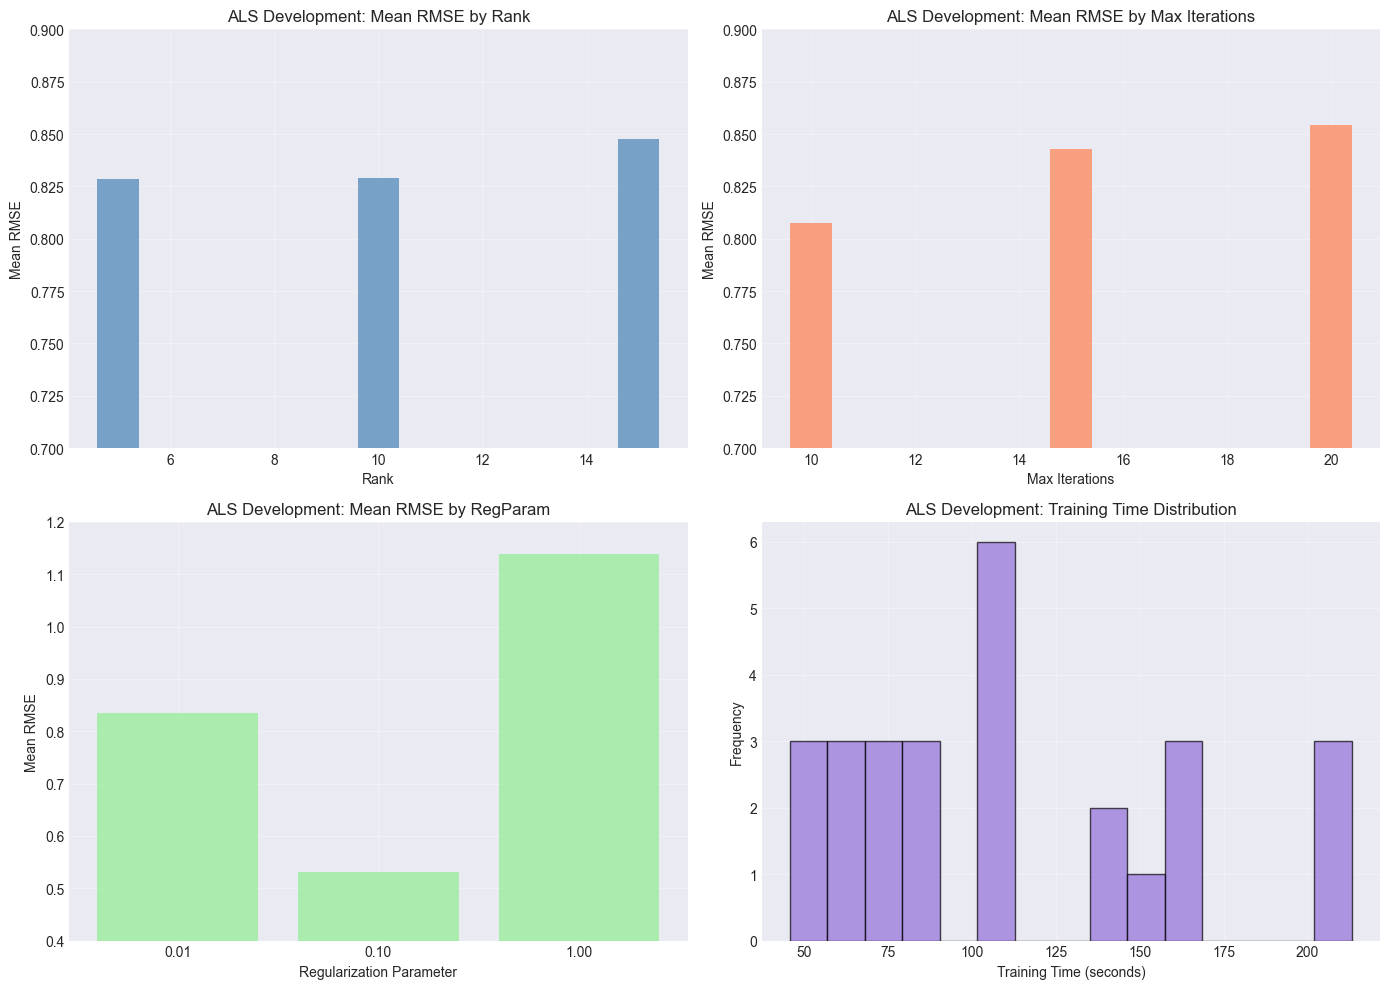


SELECTING TOP 3 CONFIGURATIONS FOR PRODUCTION
  Top 3 configurations selected:

1. rank=15, maxIter=20, regParam=0.1
   Development RMSE: 0.5201
   Development MAE: 0.3417
   Development train time: 213.2s

2. rank=15, maxIter=15, regParam=0.1
   Development RMSE: 0.5222
   Development MAE: 0.3429
   Development train time: 159.5s

3. rank=10, maxIter=20, regParam=0.1
   Development RMSE: 0.5224
   Development MAE: 0.3428
   Development train time: 145.9s

These configurations will be retrained on 100% data in production phase.

SAVING DEVELOPMENT RESULTS
  Saved CSV: 04_als_development_tuning.csv
  Rows: 27
  Columns: ['run_name', 'model_type', 'model_path', 'rank', 'maxIter', 'regParam', 'coldStartStrategy', 'model_storage', 'rmse', 'mae', 'r2', 'train_time']

CLEANUP
  Caches cleared
  Spark Session stopped


In [42]:
# DEVELOPMENT RESULTS

print("=" * 70)
print("COLLECTING DEVELOPMENT RESULTS")
print("=" * 70)

# Get all runs
als_dev_runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string="tags.model_type = 'ALS' AND tags.phase = 'development'" 
)

# Extract run data
runs_data = []
for run in als_dev_runs:

    run_data = {'run_name': run.info.run_name}
    
    # Add tags
    run_data['model_type'] = run.data.tags['model_type']
    run_data['model_path'] = run.data.tags['model_path']
    
    # Add params
    for key, value in run.data.params.items():
        run_data[f'{key}'] = value
    
    # Add metrics
    for key, value in run.data.metrics.items():
        run_data[f'{key}'] = value
    
    runs_data.append(run_data)

# Convert to DataFrame
results_dev_als_df = pd.DataFrame(runs_data)
results_dev_als_df['rank'] = results_dev_als_df['rank'].astype(int)
results_dev_als_df['maxIter'] = results_dev_als_df['maxIter'].astype(int)
results_dev_als_df['regParam'] = results_dev_als_df['regParam'].astype(float)

# Sort by RMSE (ascending - lower is better)
results_dev_als_df = results_dev_als_df.sort_values('rmse', ascending=True).reset_index(drop=True)

print(f"Total configurations tested: {len(results_dev_als_df)}")
print(f"\nBest 5 configurations (by RMSE):")
print(results_dev_als_df.head(5).to_string(index=False))

print(f"\nWorst 5 configurations (by RMSE):")
print(results_dev_als_df.tail(5).to_string(index=False))

# Statistics
print(f"\nResults statistics:")
print(f"  Best RMSE: {results_dev_als_df['rmse'].min():.4f}")
print(f"  Worst RMSE: {results_dev_als_df['rmse'].max():.4f}")
print(f"  Mean RMSE: {results_dev_als_df['rmse'].mean():.4f}")
print(f"  Std RMSE: {results_dev_als_df['rmse'].std():.4f}")
print(f"  Avg train time: {results_dev_als_df['train_time'].mean():.1f}s")

# Analyze Development Results

print("\n" + "=" * 70)
print("DEVELOPMENT RESULTS ANALYSIS")
print("=" * 70)

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: RMSE by rank
ax1 = axes[0, 0]
rank_groups = results_dev_als_df.groupby('rank')['rmse'].mean().sort_index()
ax1.bar(rank_groups.index, rank_groups.values, color='steelblue', alpha=0.7)
ax1.set_xlabel('Rank')
ax1.set_ylabel('Mean RMSE')
ax1.set_title('ALS Development: Mean RMSE by Rank')
ax1.set_ylim(0.7, 0.9)
ax1.grid(True, alpha=0.3)

# Plot 2: RMSE by maxIter
ax2 = axes[0, 1]
iter_groups = results_dev_als_df.groupby('maxIter')['rmse'].mean().sort_index()
ax2.bar(iter_groups.index, iter_groups.values, color='coral', alpha=0.7)
ax2.set_xlabel('Max Iterations')
ax2.set_ylabel('Mean RMSE')
ax2.set_title('ALS Development: Mean RMSE by Max Iterations')
ax2.set_ylim(0.7, 0.9)
ax2.grid(True, alpha=0.3)

# Plot 3: RMSE by regParam
ax3 = axes[1, 0]
reg_groups = results_dev_als_df.groupby('regParam')['rmse'].mean().sort_index()
ax3.bar(range(len(reg_groups)), reg_groups.values, color='lightgreen', alpha=0.7)
ax3.set_xticks(range(len(reg_groups)))
ax3.set_xticklabels([f'{x:.2f}' for x in reg_groups.index])
ax3.set_xlabel('Regularization Parameter')
ax3.set_ylabel('Mean RMSE')
ax3.set_title('ALS Development: Mean RMSE by RegParam')
ax3.set_ylim(0.4, 1.2)
ax3.grid(True, alpha=0.3)

# Plot 4: Training time distribution
ax4 = axes[1, 1]
ax4.hist(results_dev_als_df['train_time'], bins=15, color='mediumpurple', alpha=0.7, edgecolor='black')
ax4.set_xlabel('Training Time (seconds)')
ax4.set_ylabel('Frequency')
ax4.set_title('ALS Development: Training Time Distribution')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(GRAPH_DIR / '04_als_development_analysis.png', dpi=300, bbox_inches='tight')
print(" Saved PNG: 04_als_development_analysis.png")
plt.show()


print("\n" + "=" * 70)
print("SELECTING TOP 3 CONFIGURATIONS FOR PRODUCTION")
print("=" * 70)

# Select top configurations
top_configs_als = results_dev_als_df.head(TOP_N).to_dict('records')

print(f"  Top {TOP_N} configurations selected:\n")
for i, config in enumerate(top_configs_als, 1):
    print(f"{i}. rank={config['rank']}, maxIter={config['maxIter']}, regParam={config['regParam']}")
    print(f"   Development RMSE: {config['rmse']:.4f}")
    print(f"   Development MAE: {config['mae']:.4f}")
    print(f"   Development train time: {config['train_time']:.1f}s")
    print()

print("These configurations will be retrained on 100% data in production phase.")


print("\n" + "=" * 70)
print("SAVING DEVELOPMENT RESULTS")
print("=" * 70)

# Save complete results
results_dev_als_df.to_csv(RESULTS_DIR / '04_als_development_tuning.csv', index=False)
print(f"  Saved CSV: 04_als_development_tuning.csv")
print(f"  Rows: {len(results_dev_als_df)}")
print(f"  Columns: {list(results_dev_als_df.columns)}")

# Cleanup
print("\n" + "=" * 70)
print("CLEANUP")
print("=" * 70)
train_dev.unpersist()
test_dev.unpersist()
interactions_dev.unpersist()
print("  Caches cleared")
spark.stop()
print("  Spark Session stopped")

# ALS Production Phase

## Production Training - Full Dataset

La fase di production ri-train le **top 3 configurazioni** identificate in development su **100% del dataset**.

### MLflow Tracking

Runs di production avranno:
- **Tag**: `phase=production`, `sample_fraction=1.0`, `model_path`
- **Metrics**: RMSE, MAE,  R², train_time

In [12]:
#  SPARK SESSION CREATION

print("\n" + "=" * 70)
print("SPARK SESSION CREATION")
print("=" * 70)

# Create Spark session using config
spark = get_spark_session("Notebook-04-PySpark-MLflow")

# Verify Spark is working
spark.sparkContext.setLogLevel("ERROR")

# Test basic operation
test_df = spark.range(10)
assert test_df.count() == 10, "Spark basic operation failed"

print("\nSpark session created successfully")


SPARK SESSION CREATION
Found 4 JAR files
Spark Session created: Notebook-04-PySpark-MLflow
Spark Version: 3.4.1
Spark UI: http://localhost:4040
Delta Lake + MinIO: Enabled
  S3AFileSystem loaded successfully

Spark session created successfully


In [13]:
# LOAD & SPLIT FULL DATA (100%)

print("=" * 70)
print("ALS PRODUCTION PHASE (100% DATA)")
print("=" * 70)

print("Loading full dataset for production training...")
start_time = time.time()

print("\n[1/2] Loading user-item interactions...")
try:
    interactions_full = spark.read.format("delta").load(DATA_PATHS['user_item_interactions'])
    interactions_count = interactions_full.count()
    print(f"  Loaded {interactions_count:,} interactions")
    print(f"  Schema:")
    interactions_full.printSchema()
    
except Exception as e:
    print(f"  Error loading interactions: {e}")
    raise

load_time = time.time() - start_time

print(f"  Full dataset ready: {interactions_count:,} interactions")
print(f"  Verification time: {load_time:.1f} seconds")

print("=" * 70)
print("TRAIN/TEST SPLIT (PRODUCTION)")
print("=" * 70)

# Split data 
print(f"Splitting full data ({TRAIN_RATIO}/{TEST_RATIO})...")
start_time = time.time()

train_prod, test_prod = interactions_full.randomSplit([TRAIN_RATIO, TEST_RATIO], seed=RANDOM_SEED)

split_time = time.time() - start_time
print(f"  Split complete ({split_time:.1f}s)")

ALS PRODUCTION PHASE (100% DATA)
Loading full dataset for production training...

[1/2] Loading user-item interactions...
  Loaded 73,881,272 interactions
  Schema:
root
 |-- user_id: integer (nullable = true)
 |-- item_id: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- purchase_count: long (nullable = true)
 |-- total_spent: double (nullable = true)

  Full dataset ready: 73,881,272 interactions
  Verification time: 0.9 seconds
TRAIN/TEST SPLIT (PRODUCTION)
Splitting full data (0.8/0.2)...
  Split complete (0.0s)


In [16]:
# TRAIN PRODUCTION MODEL

print("=" * 70)
print("TRAINING PRODUCTION MODELS (TOP 3 CONFIGS)")
print("=" * 70)

# Initialize results storage
results_prod_als = []

# Evaluator
evaluator_prod = RegressionEvaluator(    # RMSE
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)

mae_eval = RegressionEvaluator(    # MAE 
    metricName="mae", 
    labelCol="rating", 
    predictionCol="prediction")

r2_eval = RegressionEvaluator(    #R2
    metricName="r2", 
    labelCol="rating", 
    predictionCol="prediction")


# Train Models

for i, config in enumerate(top_configs_als, 1):

    rank = config['rank']
    maxIter = config['maxIter']
    regParam = config['regParam']
    run_name = f"ALS_prod_r{rank}_i{maxIter}_reg{regParam}"
    
    print(f"\n[{i}/3] Training: {run_name}")

    # Model path su MinIO
    model_path = f"{MODELS_PATHS['prod_als']}/{run_name}" 

    print(f"  Config from development: RMSE={config['rmse']:.4f}")
    
    with mlflow.start_run(run_name=run_name):
        # Tags
        mlflow.set_tag("phase", "production")
        mlflow.set_tag("model_type", "ALS")
        mlflow.set_tag("sample_fraction", 1.0)
        
        # Parameters
        mlflow.log_param("rank", rank)
        mlflow.log_param("maxIter", maxIter)
        mlflow.log_param("regParam", regParam)
        mlflow.log_param("coldStartStrategy", "drop")
        
        # Train
        train_start = time.time()
        
        als = ALS(
            rank=rank,
            maxIter=maxIter,
            regParam=regParam,
            userCol="user_id",
            itemCol="item_id",
            ratingCol="rating",
            coldStartStrategy="drop",
            seed=RANDOM_SEED
        )
        
        model = als.fit(train_prod)
        train_time = time.time() - train_start
        
        # Evaluate
        predictions = model.transform(test_prod)
        rmse = evaluator_prod.evaluate(predictions)
        
        # Additional metrics
        mae = mae_eval.evaluate(predictions)
        r2 = r2_eval.evaluate(predictions)
        
        # Log metrics
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("train_time", train_time)
        
        # 5. Save model to MinIO with Spark
        print(f"  Saving model to: {model_path}")
        model.write().overwrite().save(model_path)
        
        # 6. Log model path in MLflow
        mlflow.set_tag("model_path", model_path)
        mlflow.log_param("model_storage", "minio_s3")
        
        print(f"  Run complete: Model saved to MinIO")
        
        # Store results
        results_prod_als.append({
            'rank': rank,
            'maxIter': maxIter,
            'regParam': regParam,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'train_time': train_time,
            'model_path': model_path
        })
        
        print(f"    RMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")
        print(f"    Training time: {train_time:.1f}s ({train_time/60:.1f} min)")

TRAINING PRODUCTION MODELS (TOP 3 CONFIGS)

[1/3] Training: ALS_prod_r15_i20_reg0.1
  Config from development: RMSE=0.5201
  Saving model to: s3a://bigdata-ecommerce/models/production/ALS/ALS_prod_r15_i20_reg0.1
  Run complete: Model saved to MinIO
    RMSE=0.4738, MAE=0.3166, R²=0.7546
    Training time: 297.8s (5.0 min)

[2/3] Training: ALS_prod_r15_i15_reg0.1
  Config from development: RMSE=0.5222
  Saving model to: s3a://bigdata-ecommerce/models/production/ALS/ALS_prod_r15_i15_reg0.1
  Run complete: Model saved to MinIO
    RMSE=0.4729, MAE=0.3156, R²=0.7555
    Training time: 226.2s (3.8 min)

[3/3] Training: ALS_prod_r10_i20_reg0.1
  Config from development: RMSE=0.5224
  Saving model to: s3a://bigdata-ecommerce/models/production/ALS/ALS_prod_r10_i20_reg0.1
  Run complete: Model saved to MinIO
    RMSE=0.4735, MAE=0.3163, R²=0.7549
    Training time: 224.9s (3.7 min)


## Analisi Risultati Production

Confrontiamo i risultati production con development per validare la nostra strategia.

Selezioniamo il **best production model** basandoci su:
1. **RMSE** : Valore più basso
2. **Stability**: Performance consistente tra development e production
3. **Efficiency**: A parità di RMSE, preferiamo model più veloce


In [17]:
# PRODUCTION RESULTS

print("=" * 70)
print("COLLECTING PRODUCTION RESULTS")
print("=" * 70)

# Convert to DataFrame
results_prod_als_df = pd.DataFrame(results_prod_als)

# Sort by RMSE
results_prod_als_df = results_prod_als_df.sort_values('rmse', ascending=True).reset_index(drop=True)

print("Production training complete!")
print(f"\nAll production results:")
print(results_prod_als_df.to_string(index=False))

# Statistics
print(f"\nProduction statistics:")
print(f"  Best RMSE: {results_prod_als_df['rmse'].min():.4f}")
print(f"  Worst RMSE: {results_prod_als_df['rmse'].max():.4f}")
print(f"  Mean RMSE: {results_prod_als_df['rmse'].mean():.4f}")
print(f"  Total training time: {results_prod_als_df['train_time'].sum():.1f}s ({results_prod_als_df['train_time'].sum()/60:.1f} min)")

# Analyze Production Results
print("\n" + "=" * 70)
print("PRODUCTION VS DEVELOPMENT COMPARISON")
print("=" * 70)

results_dev_als_df = pd.read_csv(RESULTS_DIR / '04_als_development_tuning.csv')

# Create comparison DataFrame
comparison_data = []
for i, prod_row in results_prod_als_df.iterrows():
    # Find corresponding dev row
    dev_row = results_dev_als_df[
        (results_dev_als_df['rank'] == prod_row['rank']) &
        (results_dev_als_df['maxIter'] == prod_row['maxIter']) &
        (results_dev_als_df['regParam'] == prod_row['regParam'])
    ].iloc[0]
    
    comparison_data.append({
        'rank': prod_row['rank'],
        'maxIter': prod_row['maxIter'],
        'regParam': prod_row['regParam'],
        'dev_rmse': dev_row['rmse'],
        'prod_rmse': prod_row['rmse'],
        'rmse_diff': prod_row['rmse'] - dev_row['rmse'],
        'dev_time': dev_row['train_time'],
        'prod_time': prod_row['train_time'],
        'time_factor': prod_row['train_time'] / dev_row['train_time']
    })

comparison_df = pd.DataFrame(comparison_data)

print("Development vs Production comparison:")
print(comparison_df.to_string(index=False))

print(f"\nKey insights:")
print(f"  Avg RMSE difference: {comparison_df['rmse_diff'].mean():.4f}")
print(f"  Avg time factor (prod/dev): {comparison_df['time_factor'].mean():.1f}x")
print(f"  RMSE correlation: {comparison_df[['dev_rmse', 'prod_rmse']].corr().iloc[0, 1]:.3f}")

# Save comparison
comparison_df.to_csv(RESULTS_DIR / '04_als_dev_vs_prod_comparison.csv', index=False)
print("\n  Saved CSV: 04_als_dev_vs_prod_comparison.csv")

# Save production results
print("\n" + "=" * 70)
print("SAVING PRODUCTION RESULTS")
print("=" * 70)

results_prod_als_df.to_csv(RESULTS_DIR / '04_als_production_final.csv', index=False)
print(f"  Saved CSV: 04_als_production_final.csv")

# Cleanup
print("\n" + "=" * 70)
print("CLEANUP")
print("=" * 70)
spark.stop()
print("  Spark Session stopped")

COLLECTING PRODUCTION RESULTS
Production training complete!

All production results:
 rank  maxIter  regParam     rmse      mae       r2  train_time                                                            model_path
   15       15       0.1 0.472912 0.315632 0.755512  226.218787 s3a://bigdata-ecommerce/models/production/ALS/ALS_prod_r15_i15_reg0.1
   10       20       0.1 0.473547 0.316296 0.754854  224.902040 s3a://bigdata-ecommerce/models/production/ALS/ALS_prod_r10_i20_reg0.1
   15       20       0.1 0.473841 0.316597 0.754551  297.754986 s3a://bigdata-ecommerce/models/production/ALS/ALS_prod_r15_i20_reg0.1

Production statistics:
  Best RMSE: 0.4729
  Worst RMSE: 0.4738
  Mean RMSE: 0.4734
  Total training time: 748.9s (12.5 min)

PRODUCTION VS DEVELOPMENT COMPARISON
Development vs Production comparison:
 rank  maxIter  regParam  dev_rmse  prod_rmse  rmse_diff   dev_time  prod_time  time_factor
   15       15       0.1  0.522228   0.472912  -0.049316 159.499928 226.218787     1.

# Random Forest Classification

## Random Forest Classifier

**Random Forest** è un ensemble method per classificazione che combina multiple decision trees.

### Come Funziona

1. **Bootstrap Aggregating (Bagging)**:
   - Crea N dataset di training tramite sampling con replacement
   - Allena un decision tree su ogni dataset

2. **Random Feature Selection**:
   - Ogni tree usa un subset random di features
   - Riduce correlation tra trees
   - Migliora generalizzazione

3. **Voting**:
   - Predizione finale = majority vote di tutti i trees
   - Per probabilità: average delle probabilità di tutti i trees

### Use Case E-commerce

**Obiettivo**: Classificare customers in segmenti per marketing personalizzato

**Segmenti**:
- **VIP** (~5%): High spenders, loyal customers
- **Regular** (~35%): Medium spenders, regular purchases
- **Occasional** (~60%): Low spenders, infrequent purchases

**Features**:
- RFM (Recency, Frequency, Monetary)
- Demographics (age, region)
- Behavioral (avg_transaction)

**Output**: Customer segment prediction + probability

### Iperparametri

**numTrees**: Numero di trees (10-70)  
**maxDepth**: Profondità massima tree (5-15)  
**featureSubsetStrategy**: Features per split (auto = √n_features)  

## Development Phase - Esplorazione Iperparametri

Similmente ad ALS, usiamo **20% sample** per l'esplorazione degli iperparametri.

### Grid Search Strategy

Testeremo **16 combinazioni**:
- `numTrees`: [10, 30, 50, 70]
- `maxDepth`: [5, 10, 15, 20]

### Feature Engineering Pipeline

Prima del training, costruiamo una pipeline di preprocessing:

1. **StringIndexer** per `region` (categorica → numerica)
2. **StringIndexer** per `customer_segment` (label → numerica)
3. **VectorAssembler** per combinare features in un vector

Pipeline garantisce:
- Preprocessing consistente su train/test
- Facile applicazione a nuovi dati
- Gestione automatica di missing values

### MLflow Tracking

Ogni run sarà tracciato con:
- **Tag**: `phase=development`, `sample_fraction=0.2`, `model_path`
- **Params**: numTrees, maxDepth
- **Metrics**: Accuracy, F1, train_time


In [5]:
# SPARK SESSION CREATION

print("\n" + "=" * 70)
print("SPARK SESSION CREATION")
print("=" * 70)

# Create Spark session using config
spark = get_spark_session("Notebook-04-PySpark-MLflow")

# Verify Spark is working
spark.sparkContext.setLogLevel("ERROR")

# Test basic operation
test_df = spark.range(10)
assert test_df.count() == 10, "Spark basic operation failed"

print("\nSpark session created successfully")


SPARK SESSION CREATION
Found 4 JAR files
Spark Session created: Notebook-04-PySpark-MLflow
Spark Version: 3.4.1
Spark UI: http://localhost:4040
Delta Lake + MinIO: Enabled
  S3AFileSystem loaded successfully

Spark session created successfully


In [6]:
# LOAD & SPLIT SAMPLE DATA (20%)

print("=" * 70)
print("RANDOM FOREST DEVELOPMENT PHASE (20% SAMPLE)")
print("=" * 70)
# Load customer features (for Random Forest)

print("\nLoading customer features...")
try:
    customers_full = spark.read.format("delta").load(DATA_PATHS['customer_features'])
    customers_count = customers_full.count()
    print(f"  Loaded {customers_count:,} customer records")
    print(f"  Schema: ")
    customers_full.printSchema()
    
except Exception as e:
    print(f"  Error loading customers: {e}")
    raise
# Configuration

print(f"Development configuration:")
print(f"  Sample fraction: {SAMPLE_FRACTION_DEV} ({SAMPLE_FRACTION_DEV*100:.0f}%)")
print(f"  Train/test split: {TRAIN_RATIO}/{TEST_RATIO}")
print(f"  Random seed: {RANDOM_SEED}")

# Load sample
print(f"\nLoading {SAMPLE_FRACTION_DEV*100:.0f}% sample for development...")
start_time = time.time()

customers_dev = customers_full.sample(fraction=SAMPLE_FRACTION_DEV, seed=RANDOM_SEED)
customers_dev.cache()

customers_dev_count = customers_dev.count()
load_time = time.time() - start_time

print(f"  Sample loaded: {customers_dev_count:,} customers")
print(f"  Load time: {load_time:.1f} seconds")


print("\n" + "=" * 70)
print("TRAIN/TEST SPLIT (DEVELOPMENT)")
print("=" * 70)

# Split data
print(f"Splitting data ({TRAIN_RATIO}/{TEST_RATIO})...")
train_dev_rf, test_dev_rf = customers_dev.randomSplit([TRAIN_RATIO, TEST_RATIO], seed=RANDOM_SEED)

# Cache for reuse
train_dev_rf.cache()
test_dev_rf.cache()

# Counts
train_dev_rf_count = train_dev_rf.count()
test_dev_rf_count = test_dev_rf.count()

print(f"  Split complete")
print(f"  Train set: {train_dev_rf_count:,} customers ({train_dev_rf_count/customers_dev_count*100:.1f}%)")
print(f"  Test set: {test_dev_rf_count:,} customers ({test_dev_rf_count/customers_dev_count*100:.1f}%)")

# Class distribution in splits
print("\nClass distribution - Train:")
train_dev_rf.groupBy("customer_segment").count().orderBy("count", ascending=False).show()

print("Class distribution - Test:")
test_dev_rf.groupBy("customer_segment").count().orderBy("count", ascending=False).show()


RANDOM FOREST DEVELOPMENT PHASE (20% SAMPLE)

Loading customer features...
  Loaded 1,000,000 customer records
  Schema: 
root
 |-- customer_id: string (nullable = true)
 |-- recency: integer (nullable = true)
 |-- frequency: long (nullable = true)
 |-- monetary: double (nullable = true)
 |-- avg_transaction: double (nullable = true)
 |-- unique_products: long (nullable = true)
 |-- customer_segment: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- region: string (nullable = true)
 |-- is_churned: integer (nullable = true)

Development configuration:
  Sample fraction: 0.2 (20%)
  Train/test split: 0.8/0.2
  Random seed: 42

Loading 20% sample for development...
  Sample loaded: 200,294 customers
  Load time: 2.7 seconds

TRAIN/TEST SPLIT (DEVELOPMENT)
Splitting data (0.8/0.2)...
  Split complete
  Train set: 160,305 customers (80.0%)
  Test set: 39,989 customers (20.0%)

Class distribution - Train:
+----------------+-----+
|customer_segment|count|
+----------------+--

In [7]:
# TRANSFORM FEATURES

print("=" * 70)
print("FEATURE ENGINEERING PIPELINE")
print("=" * 70)

# Define feature columns
numeric_features = ['recency', 'frequency', 'monetary', 'avg_transaction', 'unique_products', 'age']
categorical_features = ['region']

print("Features:")
print(f"  Numeric: {numeric_features}")
print(f"  Categorical: {categorical_features}")

# Stage 1: StringIndexer for categorical features
print("\n[1/3] StringIndexer for categorical features...")
string_indexer = StringIndexer(
    inputCol="region",
    outputCol="region_indexed",
    handleInvalid="keep"
)

# Stage 2: StringIndexer for label
print("[2/3] StringIndexer for label (customer_segment)...")
label_indexer = StringIndexer(
    inputCol="customer_segment",
    outputCol="label",
    handleInvalid="keep"
)

# Stage 3: VectorAssembler
print("[3/3] VectorAssembler...")
feature_cols = numeric_features + ["region_indexed"]
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features",
    handleInvalid="keep"
)

print("\n  Feature pipeline defined")
print(f"  Input features: {len(feature_cols)}")
print(f"  Output: 'features' vector column")

print("\n" + "=" * 80)
print("APPLYING FEATURE TRANSFORMATIONS (DEVELOPMENT)")
print("=" * 80)

# Fit and transform string indexers
print("Fitting StringIndexers...")
string_indexer_model = string_indexer.fit(train_dev_rf)
label_indexer_model = label_indexer.fit(train_dev_rf)

# Transform train
print("\nTransforming train set...")
train_dev_rf_indexed = string_indexer_model.transform(train_dev_rf)
train_dev_rf_indexed = label_indexer_model.transform(train_dev_rf_indexed)
train_dev_rf_transformed = assembler.transform(train_dev_rf_indexed)
train_dev_rf_transformed.cache()

# Transform test
print("Transforming test set...")
test_dev_rf_indexed = string_indexer_model.transform(test_dev_rf)
test_dev_rf_indexed = label_indexer_model.transform(test_dev_rf_indexed)
test_dev_rf_transformed = assembler.transform(test_dev_rf_indexed)
test_dev_rf_transformed.cache()

print("\n  Features transformed")

# Show sample
print("\nSample transformed features:")
train_dev_rf_transformed.select("customer_id", "customer_segment", "label", "features").show(5, truncate=False)

# Get number of classes
num_classes = train_dev_rf_transformed.select("label").distinct().count()
print(f"\nNumber of classes: {num_classes}")



FEATURE ENGINEERING PIPELINE
Features:
  Numeric: ['recency', 'frequency', 'monetary', 'avg_transaction', 'unique_products', 'age']
  Categorical: ['region']

[1/3] StringIndexer for categorical features...
[2/3] StringIndexer for label (customer_segment)...
[3/3] VectorAssembler...

  Feature pipeline defined
  Input features: 7
  Output: 'features' vector column

APPLYING FEATURE TRANSFORMATIONS (DEVELOPMENT)
Fitting StringIndexers...

Transforming train set...
Transforming test set...

  Features transformed

Sample transformed features:
+-----------+----------------+-----+----------------------------------------------------------------+
|customer_id|customer_segment|label|features                                                        |
+-----------+----------------+-----+----------------------------------------------------------------+
|C00000177  |Occasional      |0.0  |[400.0,46.0,11894.489999999998,258.5758695652174,36.0,42.0,12.0]|
|C00000433  |VIP             |2.0  |[387.0,31

In [21]:
# GRID SEARCH LOOP DEVELPOMENT

print("=" * 70)
print("RANDOM FOREST HYPERPARAMETER GRID SEARCH (DEVELOPMENT)")
print("=" * 70)

# Define hyperparameter grid
param_grid_rf = {
    'numTrees': [10, 30, 50, 70],
    'maxDepth': [5, 10, 15, 20]
}

# Generate all combinations
all_combinations_rf = list(itertools.product(
    param_grid_rf['numTrees'],
    param_grid_rf['maxDepth']
))

# Number of combinations
n_combinations = len(all_combinations_rf)

print(f"Hyperparameter grid:")
print(f"  numTrees: {param_grid_rf['numTrees']}")
print(f"  maxDepth: {param_grid_rf['maxDepth']}")
print(f"\nTotal combinations: {n_combinations}")

# Initialize results storage
results_dev_rf = []

# Evaluators
acc_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)

print(f"\nStarting grid search...")
print("=" * 70)

# Grid search
for i, (numTrees, maxDepth) in enumerate(all_combinations_rf, 1):
    
    run_name = f"RF_dev_t{numTrees}_d{maxDepth}"
    
    # Model path MinIO
    model_path = f"{MODELS_PATHS['dev_rf']}/{run_name}" 

    print(f"\n[{i}/{n_combinations}] Training: {run_name}")
    
    with mlflow.start_run(run_name=run_name):
        # Tags
        mlflow.set_tag("phase", "development")
        mlflow.set_tag("model_type", "RandomForest")
        mlflow.set_tag("sample_fraction", SAMPLE_FRACTION_DEV)
        
        # Parameters
        mlflow.log_param("numTrees", numTrees)
        mlflow.log_param("maxDepth", maxDepth)
        mlflow.log_param("featureSubsetStrategy", "auto")
        
        # Train
        train_start = time.time()
        
        rf = RandomForestClassifier(
            numTrees=numTrees,
            maxDepth=maxDepth,
            featuresCol="features",
            labelCol="label",
            seed=RANDOM_SEED,
            featureSubsetStrategy="auto"
        )
        
        model = rf.fit(train_dev_rf_transformed)
        train_time = time.time() - train_start
        
        # Evaluate
        predictions = model.transform(test_dev_rf_transformed)
        
        accuracy = acc_evaluator.evaluate(predictions)
        f1 = f1_evaluator.evaluate(predictions)
        
        # Log metrics
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("f1", f1)
        mlflow.log_metric("train_time", train_time)
        
        # Save model to MinIO with Spark
        print(f"  Saving model to: {model_path}")
        model.write().overwrite().save(model_path)
        
        # Log model path in MLflow
        mlflow.set_tag("model_path", model_path)
        mlflow.log_param("model_storage", "minio_s3")
        
        # Store results
        results_dev_rf.append({
            'numTrees': numTrees,
            'maxDepth': maxDepth,
            'accuracy': accuracy,
            'f1': f1,
            'train_time': train_time,
            'model_path': model_path
        })
        
        print(f"  Accuracy={accuracy:.4f}, F1={f1:.4f}, Time={train_time:.1f}s")


RANDOM FOREST HYPERPARAMETER GRID SEARCH (DEVELOPMENT)
Hyperparameter grid:
  numTrees: [10, 30, 50, 70]
  maxDepth: [5, 10, 15, 20]

Total combinations: 16

Starting grid search...

[1/16] Training: RF_dev_t10_d5
  Saving model to: s3a://bigdata-ecommerce/models/development/RF/RF_dev_t10_d5
  Accuracy=0.9986, F1=0.9986, Time=1.4s

[2/16] Training: RF_dev_t10_d10
  Saving model to: s3a://bigdata-ecommerce/models/development/RF/RF_dev_t10_d10
  Accuracy=0.9987, F1=0.9987, Time=1.3s

[3/16] Training: RF_dev_t10_d15
  Saving model to: s3a://bigdata-ecommerce/models/development/RF/RF_dev_t10_d15
  Accuracy=0.9987, F1=0.9987, Time=1.7s

[4/16] Training: RF_dev_t10_d20
  Saving model to: s3a://bigdata-ecommerce/models/development/RF/RF_dev_t10_d20
  Accuracy=0.9986, F1=0.9986, Time=2.3s

[5/16] Training: RF_dev_t30_d5
  Saving model to: s3a://bigdata-ecommerce/models/development/RF/RF_dev_t30_d5
  Accuracy=0.9986, F1=0.9986, Time=1.1s

[6/16] Training: RF_dev_t30_d10
  Saving model to: s3a:/

## Analisi Risultati Development

Analizziamo i risultati della grid search per identificare pattern e selezionare le migliori tre configurazioni basadoci su:.

1. **Accuracy** (primario): Valore più alto
2. **Training time** (secondario): A parità di Accuracy, preferiamo model più veloci
3. **Generalizzazione**: Configurazioni non troppo complesse (evitare overfitting)

Le top 3 configs selzionate saranno ri-trainate su **100% data** nella fase di production.

COLLECTING DEVELOPMENT RESULTS (RF)
Total configurations tested: 19

All configurations (sorted by accuracy):
       run_name   model_type  numTrees  maxDepth featureSubsetStrategy model_storage  accuracy       f1  train_time
 RF_dev_t50_d15 RandomForest        50        15                  auto      minio_s3  0.998750 0.998753    4.787528
 RF_dev_t30_d10 RandomForest        30        10                  auto      minio_s3  0.998725 0.998729    1.803885
 RF_dev_t10_d10 RandomForest        10        10                  auto      minio_s3  0.998725 0.998729    1.295903
 RF_dev_t10_d15 RandomForest        10        15                  auto      minio_s3  0.998725 0.998728    1.727272
 RF_dev_t50_d20 RandomForest        50        20                  auto      minio_s3  0.998700 0.998703    7.392071
 RF_dev_t30_d15 RandomForest        30        15                  auto      minio_s3  0.998700 0.998703    3.312257
 RF_dev_t30_d20 RandomForest        30        20                  auto      mi

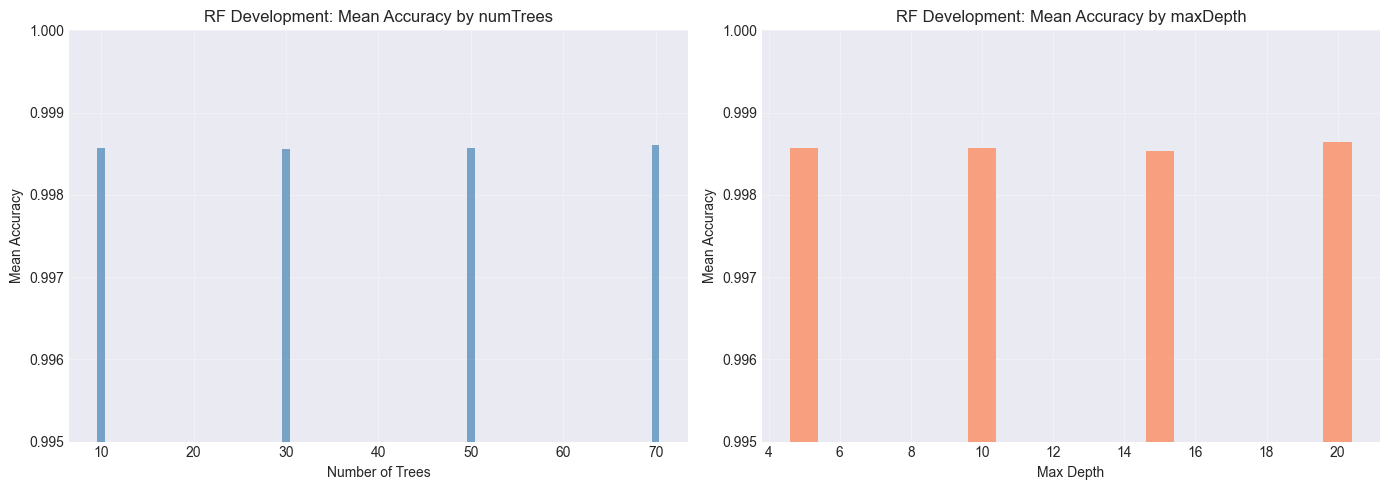


SELECTING TOP 3 CONFIGURATIONS FOR PRODUCTION (RF)
 Top 3 configurations selected:

1. numTrees=50, maxDepth=15
   Development accuracy: 0.9987
   Development F1: 0.9988
   Development train time: 4.8s

2. numTrees=30, maxDepth=10
   Development accuracy: 0.9987
   Development F1: 0.9987
   Development train time: 1.8s

3. numTrees=10, maxDepth=10
   Development accuracy: 0.9987
   Development F1: 0.9987
   Development train time: 1.3s


SAVING DEVELOPMENT RESULTS (RF)
 Saved: 04_rf_development_tuning.csv
  Rows: 19
  Columns: ['run_name', 'model_type', 'numTrees', 'maxDepth', 'featureSubsetStrategy', 'model_storage', 'accuracy', 'f1', 'train_time']

Cleaning up development caches...
 Caches cleared
 Spark Session stopped


In [45]:
# DEVELOPMENT RESULTS

print("=" * 70)
print("COLLECTING DEVELOPMENT RESULTS (RF)")
print("=" * 70)

# Get runs
rf_dev_runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string="tags.model_type = 'RandomForest'" 
)

# Extract run data
runs_data = []
for run in rf_dev_runs:

    run_data = {
        'run_name': run.info.run_name,
    }
    # Add tags
    run_data['model_type'] = run.data.tags['model_type']

    # Add params
    for key, value in run.data.params.items():
        run_data[f'{key}'] = value
    
    # Add metrics
    for key, value in run.data.metrics.items():
        run_data[f'{key}'] = value
    
    runs_data.append(run_data)
runs_data
len(runs_data)

# Convert to DataFrame
results_dev_rf_df = pd.DataFrame(runs_data)
results_dev_rf_df['numTrees']=results_dev_rf_df['numTrees'].astype(int)
results_dev_rf_df['maxDepth']=results_dev_rf_df['maxDepth'].astype(int)


# Sort by accuracy (descending - higher is better)
results_dev_rf_df = results_dev_rf_df.sort_values('accuracy', ascending=False).reset_index(drop=True)

print(f"Total configurations tested: {len(results_dev_rf_df)}")
print(f"\nAll configurations (sorted by accuracy):")
print(results_dev_rf_df.to_string(index=False))

# Statistics
print(f"\nResults statistics:")
print(f"  Best accuracy: {results_dev_rf_df['accuracy'].max():.4f}")
print(f"  Worst accuracy: {results_dev_rf_df['accuracy'].min():.4f}")
print(f"  Mean accuracy: {results_dev_rf_df['accuracy'].mean():.4f}")
print(f"  Std accuracy: {results_dev_rf_df['accuracy'].std():.4f}")
print(f"  Avg train time: {results_dev_rf_df['train_time'].mean():.1f}s")

# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy by numTrees
ax1 = axes[0]
trees_groups = results_dev_rf_df.groupby('numTrees')['accuracy'].mean().sort_index()
ax1.bar(trees_groups.index, trees_groups.values, color='steelblue', alpha=0.7)
ax1.set_xlabel('Number of Trees')
ax1.set_ylabel('Mean Accuracy')
ax1.set_title('RF Development: Mean Accuracy by numTrees')
ax1.set_ylim(0.995, 1)
ax1.grid(True, alpha=0.3)

# Plot 2: Accuracy by maxDepth
ax2 = axes[1]
depth_groups = results_dev_rf_df.groupby('maxDepth')['accuracy'].mean().sort_index()
ax2.bar(depth_groups.index, depth_groups.values, color='coral', alpha=0.7)
ax2.set_xlabel('Max Depth')
ax2.set_ylabel('Mean Accuracy')
ax2.set_title('RF Development: Mean Accuracy by maxDepth')
ax2.set_ylim(0.995, 1)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(GRAPH_DIR / '04_rf_development_analysis.png', dpi=300, bbox_inches='tight')
print("\n  Saved PNG: 04_rf_development_analysis.png")
plt.show()

# Select Top 3 Configurations

print("\n" + "=" * 70)
print("SELECTING TOP 3 CONFIGURATIONS FOR PRODUCTION (RF)")
print("=" * 70)

# Select top configurations (by accuracy)
top_configs_rf = results_dev_rf_df.head(TOP_N).to_dict('records')

print(f" Top {TOP_N} configurations selected:\n")
for i, config in enumerate(top_configs_rf, 1):
    print(f"{i}. numTrees={config['numTrees']}, maxDepth={config['maxDepth']}")
    print(f"   Development accuracy: {config['accuracy']:.4f}")
    print(f"   Development F1: {config['f1']:.4f}")
    print(f"   Development train time: {config['train_time']:.1f}s")
    print()

print("\n" + "=" * 70)
print("SAVING DEVELOPMENT RESULTS (RF)")
print("=" * 70)

# Save complete results
results_dev_rf_df.to_csv(RESULTS_DIR / '04_rf_development_tuning.csv', index=False)
print(f" Saved: {'04_rf_development_tuning.csv'}")
print(f"  Rows: {len(results_dev_rf_df)}")
print(f"  Columns: {list(results_dev_rf_df.columns)}")

# Cleanup development cache
print("\nCleaning up development caches...")
train_dev_rf.unpersist()
test_dev_rf.unpersist()
train_dev_rf_transformed.unpersist()
test_dev_rf_transformed.unpersist()
customers_dev.unpersist()
print(" Caches cleared")
spark.stop()
print(" Spark Session stopped")

# Random Forest Production Phase

## Production Training - Full Dataset

La fase di production ri-train le **top 3 configurazioni** identificate in development su **100% del dataset**.

## MLflow Tracking

Ogni run sarà tracciato con:
- **Tag**: `phase=development`, `sample_fraction=1.0`, `model_path`
- **Params**: numTrees, maxDepth
- **Metrics**: Accuracy, F1, train_time

In [23]:
# SPARK SESSION CREATION

print("\n" + "=" * 70)
print("SPARK SESSION CREATION")
print("=" * 70)

# Create Spark session using config
spark = get_spark_session("Notebook-04-PySpark-MLflow")

# Verify Spark is working
spark.sparkContext.setLogLevel("ERROR")

# Test basic operation
test_df = spark.range(10)
assert test_df.count() == 10, "Spark basic operation failed"

print("\nSpark session created successfully")


SPARK SESSION CREATION
Found 4 JAR files
Spark Session created: Notebook-04-PySpark-MLflow
Spark Version: 3.4.1
Spark UI: http://localhost:4040
Delta Lake + MinIO: Enabled
  S3AFileSystem loaded successfully

Spark session created successfully


In [24]:
# LOAD & SPLIT FULL DATA (10%0)

print("=" * 70)
print("RF PRODUCTION PHASE (100% DATA)")
print("=" * 70)

print("Loading full customer dataset for production training...")
start_time = time.time()

print("\nLoading customer features...")
try:
    customers_full = spark.read.format("delta").load(DATA_PATHS['customer_features'])
    customers_count = customers_full.count()
    print(f"  Loaded {customers_count:,} customer records")
    print(f"  Schema: {customers_full.columns}")
    customers_full.printSchema()
    
    # Sample preview
    print("\n  Sample data:")
    customers_full.show(5, truncate=False)
    
    # Class distribution
    print("\n  Class distribution:")
    customers_full.groupBy("customer_segment").count().orderBy("count", ascending=False).show()
    
except Exception as e:
    print(f"  Error loading customers: {e}")
    raise

load_time = time.time() - start_time

print(f"  Full dataset ready: {customers_count:,} customers")
print(f"  Verification time: {load_time:.1f} seconds")

# Compare with development
dev_customers_recorded = int(customers_count * SAMPLE_FRACTION_DEV)
print(f"\nData comparison:")
print(f"  Development (20%): ~{dev_customers_recorded:,} customers")
print(f"  Production (100%): {customers_count:,} customers")
print(f"  Scale factor: {customers_count/dev_customers_recorded:.1f}x")

print("=" * 70)
print("TRAIN/TEST SPLIT (PRODUCTION)")
print("=" * 70)

print(f"Splitting full data ({TRAIN_RATIO}/{TEST_RATIO})...")
train_prod_rf, test_prod_rf = customers_full.randomSplit([TRAIN_RATIO, TEST_RATIO], seed=RANDOM_SEED)

# No count yet - will count during caching
print("  Split complete")

RF PRODUCTION PHASE (100% DATA)
Loading full customer dataset for production training...

Loading customer features...
  Loaded 1,000,000 customer records
  Schema: ['customer_id', 'recency', 'frequency', 'monetary', 'avg_transaction', 'unique_products', 'customer_segment', 'age', 'region', 'is_churned']
root
 |-- customer_id: string (nullable = true)
 |-- recency: integer (nullable = true)
 |-- frequency: long (nullable = true)
 |-- monetary: double (nullable = true)
 |-- avg_transaction: double (nullable = true)
 |-- unique_products: long (nullable = true)
 |-- customer_segment: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- region: string (nullable = true)
 |-- is_churned: integer (nullable = true)


  Sample data:
+-----------+-------+---------+------------------+------------------+---------------+----------------+---+---------------------+----------+
|customer_id|recency|frequency|monetary          |avg_transaction   |unique_products|customer_segment|age|region 

In [25]:
# TRANSFORM FEATURES

print("=" * 70)
print("APPLYING FEATURE TRANSFORMATIONS (PRODUCTION)")
print("=" * 70)

# Define feature columns
numeric_features = ['recency', 'frequency', 'monetary', 'avg_transaction', 'unique_products', 'age']
categorical_features = ['region']


# Fit indexers on full training data
print("Fitting StringIndexers on production data...")
string_indexer_prod = StringIndexer(
    inputCol="region",
    outputCol="region_indexed",
    handleInvalid="keep"
)
string_indexer_model_prod = string_indexer_prod.fit(train_prod_rf)

label_indexer_prod = StringIndexer(
    inputCol="customer_segment",
    outputCol="label",
    handleInvalid="keep"
)
label_indexer_model_prod = label_indexer_prod.fit(train_prod_rf)

# Assembler (same as development)
assembler_prod = VectorAssembler(
    inputCols=numeric_features + ["region_indexed"],
    outputCol="features",
    handleInvalid="keep"
)

# Transform train
print("\nTransforming train set...")
train_prod_rf_indexed = string_indexer_model_prod.transform(train_prod_rf)
train_prod_rf_indexed = label_indexer_model_prod.transform(train_prod_rf_indexed)
train_prod_rf_transformed = assembler_prod.transform(train_prod_rf_indexed)
train_prod_rf_transformed.cache()

train_prod_rf_count = train_prod_rf_transformed.count()
print(f"  Train transformed and cached: {train_prod_rf_count:,} customers")

# Transform test
print("\nTransforming test set...")
test_prod_rf_indexed = string_indexer_model_prod.transform(test_prod_rf)
test_prod_rf_indexed = label_indexer_model_prod.transform(test_prod_rf_indexed)
test_prod_rf_transformed = assembler_prod.transform(test_prod_rf_indexed)
test_prod_rf_transformed.cache()

test_prod_rf_count = test_prod_rf_transformed.count()
print(f"  Test transformed and cached: {test_prod_rf_count:,} customers")

# Split verification
total_prod_rf = train_prod_rf_count + test_prod_rf_count
print(f"\nSplit verification:")
print(f"  Train: {train_prod_rf_count:,} ({train_prod_rf_count/total_prod_rf*100:.1f}%)")
print(f"  Test: {test_prod_rf_count:,} ({test_prod_rf_count/total_prod_rf*100:.1f}%)")
print(f"  Total: {total_prod_rf:,}")

print("\n  Production data ready for training")

APPLYING FEATURE TRANSFORMATIONS (PRODUCTION)
Fitting StringIndexers on production data...

Transforming train set...
  Train transformed and cached: 799,610 customers

Transforming test set...
  Test transformed and cached: 200,390 customers

Split verification:
  Train: 799,610 (80.0%)
  Test: 200,390 (20.0%)
  Total: 1,000,000

  Production data ready for training


In [26]:
# TRAIN PRODUCTION MODELS

print("=" * 70)
print("TRAINING PRODUCTION MODELS (TOP 3 CONFIGS)")
print("=" * 70)

# Initialize results storage
results_prod_rf = []

# Evaluators (production)
acc_evaluator_prod = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

f1_evaluator_prod = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)

for i, config in enumerate(top_configs_rf, 1):

    numTrees = config['numTrees']
    maxDepth = config['maxDepth']

    run_name = f"RF_prod_t{numTrees}_d{maxDepth}"

    # Model path MinIO
    model_path = f"{MODELS_PATHS['prod_rf']}/{run_name}" 

    print(f"\n[{i}/{TOP_N}] Training: {run_name}")
    print(f"  Config from development: Accuracy={config['accuracy']:.4f}")

    with mlflow.start_run(run_name=run_name):
        
        # Tags
        mlflow.set_tag("phase", "production")
        mlflow.set_tag("model_type", "RandomForest")
        mlflow.set_tag("sample_fraction", 1.0)
        
        # Parameters
        mlflow.log_param("numTrees", numTrees)
        mlflow.log_param("maxDepth", maxDepth)
        mlflow.log_param("featureSubsetStrategy", "auto")
        
        # Train
        train_start = time.time()
        
        rf = RandomForestClassifier(
            numTrees=numTrees,
            maxDepth=maxDepth,
            featuresCol="features",
            labelCol="label",
            seed=RANDOM_SEED,
            featureSubsetStrategy="auto"
        )
        
        model = rf.fit(train_prod_rf_transformed)
        train_time = time.time() - train_start
        
        # Evaluate
        predictions = model.transform(test_prod_rf_transformed)
        
        accuracy = acc_evaluator_prod.evaluate(predictions)
        f1 = f1_evaluator_prod.evaluate(predictions)
        
        # Log metrics
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("f1", f1)
        mlflow.log_metric("train_time", train_time)
        
        # Save model to MinIO with Spark
        print(f"  Saving model to: {model_path}")
        model.write().overwrite().save(model_path)
            
        # Log model path in MLflow
        mlflow.set_tag("model_path", model_path)
        mlflow.log_param("model_storage", "minio_s3")
        
        # Store results
        results_prod_rf.append({
            'numTrees': numTrees,
            'maxDepth': maxDepth,
            'accuracy': accuracy,
            'f1': f1,
            'train_time': train_time,
            'model_path': model_path
        })
        
        print(f"    Accuracy={accuracy:.4f}, F1={f1:.4f}")
        print(f"    Training time: {train_time:.1f}s ({train_time/60:.1f} min)")

TRAINING PRODUCTION MODELS (TOP 3 CONFIGS)

[1/3] Training: RF_prod_t50_d15
  Config from development: Accuracy=0.9987
  Saving model to: s3a://bigdata-ecommerce/models/production/RF/RF_prod_t50_d15
    Accuracy=0.9982, F1=0.9982
    Training time: 16.9s (0.3 min)

[2/3] Training: RF_prod_t30_d10
  Config from development: Accuracy=0.9987
  Saving model to: s3a://bigdata-ecommerce/models/production/RF/RF_prod_t30_d10
    Accuracy=0.9981, F1=0.9982
    Training time: 6.5s (0.1 min)

[3/3] Training: RF_prod_t10_d15
  Config from development: Accuracy=0.9987
  Saving model to: s3a://bigdata-ecommerce/models/production/RF/RF_prod_t10_d15
    Accuracy=0.9982, F1=0.9982
    Training time: 4.0s (0.1 min)


## Analisi Risultati Production

Confrontiamo i risultati production con development per validare la nostra strategia.

Selezioniamo il **best production model** basandoci su:
1. **Accuracy** : Valore più alto
2. **Stability**: Performance consistente tra development e production
3. **Efficiency**: A parità di Accuracy, preferiamo model più veloce

In [27]:
# PRODUCTION RESULTS

print("=" * 70)
print("PRODUCTION RESULTS COLLECTION (RF)")
print("=" * 70)

# Convert to DataFrame
results_prod_rf_df = pd.DataFrame(results_prod_rf)

# Sort by accuracy
results_prod_rf_df = results_prod_rf_df.sort_values('accuracy', ascending=False).reset_index(drop=True)

print("Production training complete!")
print(f"\nAll production results:")
print(results_prod_rf_df.to_string(index=False))

# Statistics
print(f"\nProduction statistics:")
print(f"  Best accuracy: {results_prod_rf_df['accuracy'].max():.4f}")
print(f"  Worst accuracy: {results_prod_rf_df['accuracy'].min():.4f}")
print(f"  Mean accuracy: {results_prod_rf_df['accuracy'].mean():.4f}")
print(f"  Total training time: {results_prod_rf_df['train_time'].sum():.1f}s ({results_prod_rf_df['train_time'].sum()/60:.1f} min)")

print("\n" + "=" * 70)
print("PRODUCTION VS DEVELOPMENT COMPARISON (RF)")
print("=" * 70)

# Create comparison DataFrame
comparison_data_rf = []
for i, prod_row in results_prod_rf_df.iterrows():
    # Find corresponding dev row
    dev_row = results_dev_rf_df[
        (results_dev_rf_df['numTrees'] == prod_row['numTrees']) &
        (results_dev_rf_df['maxDepth'] == prod_row['maxDepth'])
    ].iloc[0]
    
    comparison_data_rf.append({
        'numTrees': prod_row['numTrees'],
        'maxDepth': prod_row['maxDepth'],
        'dev_accuracy': dev_row['accuracy'],
        'prod_accuracy': prod_row['accuracy'],
        'accuracy_diff': prod_row['accuracy'] - dev_row['accuracy'],
        'dev_time': dev_row['train_time'],
        'prod_time': prod_row['train_time'],
        'time_factor': prod_row['train_time'] / dev_row['train_time']
    })

comparison_rf_df = pd.DataFrame(comparison_data_rf)

print("Development vs Production comparison:")
print(comparison_rf_df.to_string(index=False))

print(f"\nKey insights:")
print(f"  Avg accuracy difference: {comparison_rf_df['accuracy_diff'].mean():.4f}")
print(f"  Avg time factor (prod/dev): {comparison_rf_df['time_factor'].mean():.1f}x")
print(f"  Accuracy correlation: {comparison_rf_df[['dev_accuracy', 'prod_accuracy']].corr().iloc[0, 1]:.3f}")

# Save comparison
comparison_rf_df.to_csv(RESULTS_DIR / '04_rf_dev_vs_prod_comparison.csv', index=False)
print("\n  Saved CSV: 04_rf_dev_vs_prod_comparison.csv")

print("\n" + "=" * 70)
print("SAVING PRODUCTION RESULTS (RF)")
print("=" * 70)

# Save production results
results_prod_rf_df.to_csv(RESULTS_DIR / '04_rf_production_final.csv', index=False)
print(f"  Saved csv: 04_rf_production_final.csv")

print("\n" + "=" * 70)
print("CLEANUP")
print("=" * 70)

print("Unpersisting cached datasets...")
train_prod_rf_transformed.unpersist()
test_prod_rf_transformed.unpersist()
print("  Caches cleared")
spark.stop()
print("  Spark Session stopped")

PRODUCTION RESULTS COLLECTION (RF)
Production training complete!

All production results:
 numTrees  maxDepth  accuracy       f1  train_time                                                   model_path
       50        15  0.998213 0.998218   16.861304 s3a://bigdata-ecommerce/models/production/RF/RF_prod_t50_d15
       10        15  0.998204 0.998208    3.970279 s3a://bigdata-ecommerce/models/production/RF/RF_prod_t10_d15
       30        10  0.998149 0.998156    6.539315 s3a://bigdata-ecommerce/models/production/RF/RF_prod_t30_d10

Production statistics:
  Best accuracy: 0.9982
  Worst accuracy: 0.9981
  Mean accuracy: 0.9982
  Total training time: 27.4s (0.5 min)

PRODUCTION VS DEVELOPMENT COMPARISON (RF)
Development vs Production comparison:
 numTrees  maxDepth  dev_accuracy  prod_accuracy  accuracy_diff  dev_time  prod_time  time_factor
       50        15      0.998750       0.998213      -0.000536  4.787528  16.861304     3.521923
       10        15      0.998725       0.998204 

# Selezione Modelli

## Modelli in MLflow

In questa parte analizziamo **tutti** gli esperimenti tracciati in MLflow per selezionare i modelli migliori.

### Esperimenti Totali

**Experiment name**: `ecommerce-ml-models`

**Runs attesi**:
- ALS Development: 27 runs (grid search)
- ALS Production: 3 runs (top configs)
- RF Development: 16 runs (grid search)
- RF Production: 3 runs (top configs)
- **Totale**: 33 runs

### Organizzazione Runs

**Tags usati per filtrare**:
- `phase`: "development" o "production"
- `model_type`: "ALS" o "RandomForest"
- `sample_fraction`: 0.2 o 1.0
- `data_size`: Numero records training set

## Confronto Modelli ALS

Compariamo i 3 modelli ALS production per selezionare il migliore secondo i criteri:

1. **RMSE più basso** (primary)
2. **Training time ragionevole** (se performance simile)
3. **Configurazione sensata** (non estrema)

### Threshold di Successo

**RMSE < 1.0**: Buono (rating range 0-5, errore <20%)  
**RMSE < 0.8**: Eccellente  
**RMSE < 0.5**: Outstanding (difficile da raggiungere)  

## Confronto Modelli RF

Compariamo i 3 modelli Random Forest production per selezionare il migliore secondo i criteri:

1. **Accuracy più alta** (primary)
2. **F1 VIP alto** (business critical)
3. **Performance stabile** tra train e test
4. **Efficiency** (se accuracy simile, preferiamo meno trees/depth)

### Threshold di Successo

**Accuracy > 85%**: Minimo accettabile (> baseline 60%)  
**Accuracy > 90%**: Buono  
**Accuracy > 95%**: Eccellente  

<img src="./screenshots/04_mlflow_runs.png" alt="MLFlow Runs" >

ALS MODELS COMPARISON (PRODUCTION)
Production ALS models (sorted by RMSE):
               run_name rank maxIter regParam     rmse      mae       r2  train_time
ALS_prod_r10_i20_reg0.1   10      20      0.1 0.473547 0.316296 0.754854  224.902040
ALS_prod_r15_i15_reg0.1   15      15      0.1 0.472912 0.315632 0.755512  226.218787
ALS_prod_r15_i20_reg0.1   15      20      0.1 0.473841 0.316597 0.754551  297.754986

ALS Statistics:
  Best RMSE: 0.4729
  Worst RMSE: 0.4738
  Mean RMSE: 0.4734
  RMSE range: 0.0009

ALS METRICS VISUALIZATION
  Saved PNG: 04_als_production_comparison.png


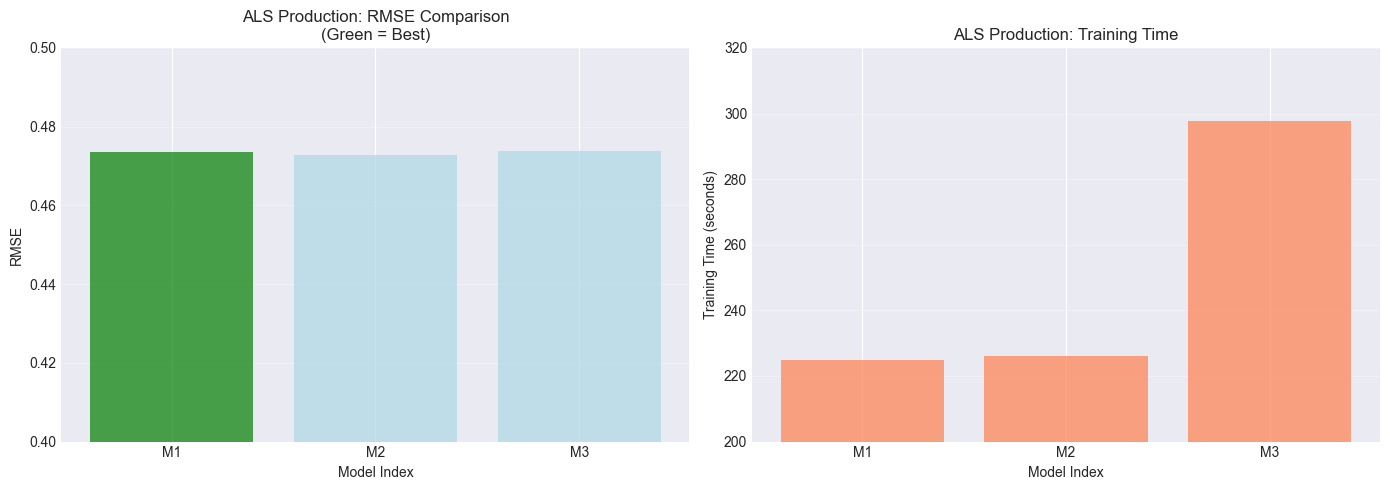

In [48]:
# ALS COMPARISON TABLE

print("=" * 70)
print("ALS MODELS COMPARISON (PRODUCTION)")
print("=" * 70)

# Get runs
als_prod_runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string="tags.model_type = 'ALS' AND tags.phase = 'production'" 
)

# Extract run data
runs_data = []
for run in als_prod_runs:

    run_data = {
        'run_name': run.info.run_name,
    }
    # Add tags
    run_data['model_type'] = run.data.tags['model_type']
    run_data['model_path'] = run.data.tags['model_path']

    # Add params
    for key, value in run.data.params.items():
        run_data[f'{key}'] = value
    
    # Add metrics
    for key, value in run.data.metrics.items():
        run_data[f'{key}'] = value
    
    runs_data.append(run_data)
runs_data
len(runs_data)

als_comparison = pd.DataFrame(runs_data)
als_comparison.sort_values(by='rmse', ascending=True)

# Display comparison table
print("Production ALS models (sorted by RMSE):")
print(als_comparison[['run_name', 'rank', 'maxIter', 'regParam', 'rmse', 'mae', 'r2', 'train_time']].to_string(index=False))

# Statistics
print(f"\nALS Statistics:")
print(f"  Best RMSE: {als_comparison['rmse'].min():.4f}")
print(f"  Worst RMSE: {als_comparison['rmse'].max():.4f}")
print(f"  Mean RMSE: {als_comparison['rmse'].mean():.4f}")
print(f"  RMSE range: {als_comparison['rmse'].max() - als_comparison['rmse'].min():.4f}")

print("\n" + "=" * 80)
print("ALS METRICS VISUALIZATION")
print("=" * 80)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: RMSE by rank
ax1 = axes[0]
for idx, row in als_comparison.iterrows():
    color = 'green' if idx == 0 else 'lightblue'
    ax1.bar(idx, row['rmse'], color=color, alpha=0.7)
ax1.set_xlabel('Model Index')
ax1.set_ylabel('RMSE')
ax1.set_title('ALS Production: RMSE Comparison\n(Green = Best)')
ax1.set_xticks(range(len(als_comparison)))
ax1.set_xticklabels([f"M{i+1}" for i in range(len(als_comparison))])
ax1.set_ylim(0.4, 0.5)
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Training time
ax2 = axes[1]
ax2.bar(range(len(als_comparison)), als_comparison['train_time'], color='coral', alpha=0.7)
ax2.set_xlabel('Model Index')
ax2.set_ylabel('Training Time (seconds)')
ax2.set_title('ALS Production: Training Time')
ax2.set_xticks(range(len(als_comparison)))
ax2.set_xticklabels([f"M{i+1}" for i in range(len(als_comparison))])
ax2.set_ylim(200, 320)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(GRAPH_DIR / '04_als_production_comparison.png', dpi=300, bbox_inches='tight')
print("  Saved PNG: 04_als_production_comparison.png")
plt.show()


RF MODELS COMPARISON (PRODUCTION)
Production RF models (sorted by Accuracy):
       run_name numTrees maxDepth  accuracy       f1  train_time
RF_prod_t10_d15       10       15  0.998204 0.998208    3.970279
RF_prod_t30_d10       30       10  0.998149 0.998156    6.539315
RF_prod_t50_d15       50       15  0.998213 0.998218   16.861304

RF Statistics:
  Best Accuracy: 0.9982
  Worst Accuracy: 0.9981
  Mean Accuracy: 0.9982
  Accuracy range: 0.0001

RF METRICS VISUALIZATION
  Saved PNG: 04_rf_production_comparison.png


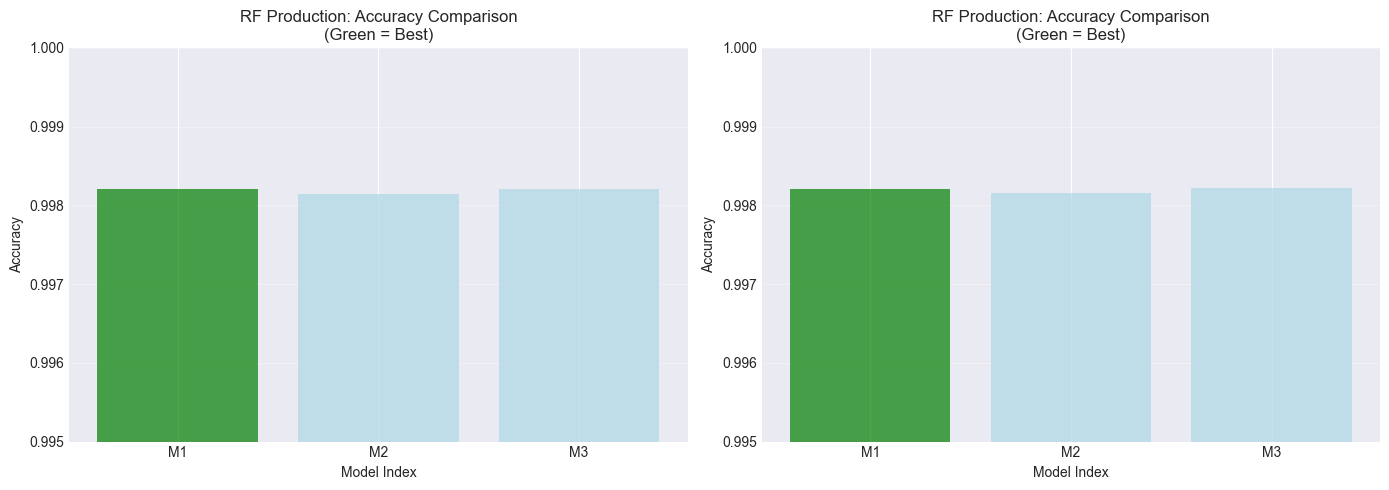

In [50]:
# RF COMPARISON TABLE

print("=" * 70)
print("RF MODELS COMPARISON (PRODUCTION)")
print("=" * 70)

# Get runs
rf_prod_runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string="tags.model_type = 'RandomForest' AND tags.phase = 'production'" 
)

# Extract run data
runs_data = []
for run in rf_prod_runs:

    run_data = {
        'run_name': run.info.run_name,
    }
    # Add tags
    run_data['model_type'] = run.data.tags['model_type']
    run_data['model_path'] = run.data.tags['model_path']

    # Add params
    for key, value in run.data.params.items():
        run_data[f'{key}'] = value
    
    # Add metrics
    for key, value in run.data.metrics.items():
        run_data[f'{key}'] = value
    
    runs_data.append(run_data)
runs_data

rf_comparison = pd.DataFrame(runs_data)
rf_comparison.sort_values(by='accuracy', ascending=True)

# Display comparison table
print("Production RF models (sorted by Accuracy):")
print(rf_comparison[['run_name', 'numTrees', 'maxDepth', 'accuracy', 'f1', 'train_time']].to_string(index=False))

# Statistics
print(f"\nRF Statistics:")
print(f"  Best Accuracy: {rf_comparison['accuracy'].max():.4f}")
print(f"  Worst Accuracy: {rf_comparison['accuracy'].min():.4f}")
print(f"  Mean Accuracy: {rf_comparison['accuracy'].mean():.4f}")
print(f"  Accuracy range: {rf_comparison['accuracy'].max() - rf_comparison['accuracy'].min():.4f}")

print("\n" + "=" * 70)
print("RF METRICS VISUALIZATION")
print("=" * 70)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy comparison
ax1 = axes[0]
for idx, row in rf_comparison.iterrows():
    color = 'green' if idx == 0 else 'lightblue'
    ax1.bar(idx, row['accuracy'], color=color, alpha=0.7)
ax1.set_xlabel('Model Index')
ax1.set_ylabel('Accuracy')
ax1.set_title('RF Production: Accuracy Comparison\n(Green = Best)')
ax1.set_xticks(range(len(rf_comparison)))
ax1.set_xticklabels([f"M{i+1}" for i in range(len(rf_comparison))])
ax1.set_ylim(0.995, 1.0)
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: F1 vs AUC
ax2 = axes[1]
for idx, row in rf_comparison.iterrows():
    color = 'green' if idx == 0 else 'lightblue'
    ax2.bar(idx, row['f1'], color=color, alpha=0.7)
ax2.set_xlabel('Model Index')
ax2.set_ylabel('Accuracy')
ax2.set_title('RF Production: Accuracy Comparison\n(Green = Best)')
ax2.set_xticks(range(len(rf_comparison)))
ax2.set_xticklabels([f"M{i+1}" for i in range(len(rf_comparison))])
ax2.set_ylim(0.995, 1.0)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(GRAPH_DIR / '04_rf_production_comparison.png', dpi=300, bbox_inches='tight')
print("  Saved PNG: 04_rf_production_comparison.png")
plt.show()


In [34]:
# SELECT BET MODEL

print("=" * 70)
print("BEST MODEL SELECTION")
print("=" * 70)

# Best ALS model (lowest RMSE)
best_als_run = als_comparison.iloc[0]

print("BEST ALS MODEL:")
print(f"  Run name:   {best_als_run['run_name']}")
print(f"  Model path: {best_als_run['model_path']}")

#print(f"  Run ID: {best_als_run['run_id']}")
print(f"  Configuration:")
print(f"    - rank:     {int(best_als_run['rank'])}")
print(f"    - maxIter:  {int(best_als_run['maxIter'])}")
print(f"    - regParam: {float(best_als_run['regParam'])}")
print(f"  Performance:")
print(f"    - RMSE: {best_als_run['rmse']:.4f}")
print(f"    - MAE:  {best_als_run['mae']:.4f}")
print(f"    - R²:   {best_als_run['r2']:.4f}")

# Best RF model (highest accuracy)
best_rf_run = rf_comparison.iloc[0]

print("\nBEST RF MODEL:")
print(f"  Run name: {best_rf_run['run_name']}")
print(f"  Model path: {best_rf_run['model_path']}")

#print(f"  Run ID: {best_rf_run['run_id']}")
print(f"  Configuration:")
print(f"    - numTrees: {int(best_rf_run['numTrees'])}")
print(f"    - maxDepth: {int(best_rf_run['maxDepth'])}")
print(f"  Performance:")
print(f"    - Accuracy: {best_rf_run['accuracy']:.4f}")
print(f"    - F1:       {best_rf_run['f1']:.4f}")

BEST MODEL SELECTION
BEST ALS MODEL:
  Run name:   ALS_prod_r10_i20_reg0.1
  Model path: s3a://bigdata-ecommerce/models/production/ALS/ALS_prod_r10_i20_reg0.1
  Configuration:
    - rank:     10
    - maxIter:  20
    - regParam: 0.1
  Performance:
    - RMSE: 0.4735
    - MAE:  0.3163
    - R²:   0.7549

BEST RF MODEL:
  Run name: RF_prod_t10_d15
  Model path: s3a://bigdata-ecommerce/models/production/RF/RF_prod_t10_d15
  Configuration:
    - numTrees: 10
    - maxDepth: 15
  Performance:
    - Accuracy: 0.9982
    - F1:       0.9982


# Production Deployment 

Tutti i modelli sono salvati in MLflow e possono essere caricati e utilizzati per eseguire predizioni su larga scala.

1. **ALS: Recommendations Generation**
   - **Input**: User-Item matrix (tutti gli users)  
   - **Output**: Top-N items per user  
   - **Method**: `model.recommendForAllUsers(N)`  

2. **RF: Customer Segmentation**
   - **Input**: Customer features (tutti i customers)  
   - **Output**: Segment prediction + probability  
   - **Method**: `model.transform(features_df)`  

Eseguiremo le predizioni con  modelli precedentemente selezionati.

In [35]:
# SPARK SESSION CREATION

print("\n" + "=" * 70)
print("SPARK SESSION CREATION")
print("=" * 70)

# Create Spark session using config
spark = get_spark_session("Notebook-04-PySpark-MLflow")

# Verify Spark is working
spark.sparkContext.setLogLevel("ERROR")

# Test basic operation
test_df = spark.range(10)
assert test_df.count() == 10, "Spark basic operation failed"

print("\nSpark session created successfully")


SPARK SESSION CREATION
Found 4 JAR files
Spark Session created: Notebook-04-PySpark-MLflow
Spark Version: 3.4.1
Spark UI: http://localhost:4040
Delta Lake + MinIO: Enabled
  S3AFileSystem loaded successfully

Spark session created successfully


In [36]:
# PREDICTIONS ALS

print("=" * 70)
print("MODEL LOADING")
print("=" * 70)

# Load ALS model
print("\nLoading ALS model...")

als_path = f"{best_als_run['model_path']}"

try:
    loaded_als_model = ALSModel.load(als_path)
    print(f"  ALS model loaded successfully")
    print(f"  Type: {type(loaded_als_model)}")  
    
except Exception as e:
    print(f"  Error loading ALS model: {e}")


print("\n" + "=" * 70)
print("BATCH PREDICTIONS PIPELINE - ALS RECOMMENDER")
print("=" * 70)

print("Generating recommendations for all users (batch processing)...")

# Use loaded model
print("\n[1/2] Generate Top-10 recommendations for all users")

start_time = time.time()

user_recs = loaded_als_model.recommendForAllUsers(10)
total_users = user_recs.count()

rec_time = time.time() - start_time

print(f"  Generated recommendations for {total_users:,} users in {rec_time:.1f}s")
print(f"  Throughput: {total_users/rec_time:.0f} users/second")

# Show sample
print("\n  Sample recommendations:")
user_recs.show(5, truncate=False)

# Explode recommendations array for analysis
print("\n  Exploding recommendations for analysis...")

recs_exploded = user_recs.select(
    F.col("user_id"),
    F.explode(F.col("recommendations")).alias("recommendation")
).select(
    F.col("user_id"),
    F.col("recommendation.item_id").alias("item_id"),
    F.col("recommendation.rating").alias("predicted_rating")
)

print("  Recommendations exploded")
print(f"  Total recommendations: {recs_exploded.count():,}")

# Show sample
print("\n  Sample exploded recommendations:")
recs_exploded.show(10, truncate=False)

# Save to Delta Lake for production serving
print("\n[2/2] Saving recommendations to Delta Lake...")
recs_output_path = f"{MODELS_PATHS['pred']}/recommendations_output"

try:
    recs_exploded.write.format("delta").mode("overwrite").save(recs_output_path)
    print(f" Saved to: {recs_output_path}")
    print("  Ready for production serving!")
except Exception as e:
    print(f" Could not save to Delta Lake: {e}")
    print("  In production, configure proper MinIO/S3 access")

print("\n  Batch predictions pipeline complete")


MODEL LOADING

Loading ALS model...
  ALS model loaded successfully
  Type: <class 'pyspark.ml.recommendation.ALSModel'>

BATCH PREDICTIONS PIPELINE - ALS RECOMMENDER
Generating recommendations for all users (batch processing)...

[1/2] Generate Top-10 recommendations for all users
  Generated recommendations for 1,000,000 users in 192.3s
  Throughput: 5201 users/second

  Sample recommendations:
+-------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_id|recommendations                                                                                                                                                               |
+-------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|4      |[{1, 6.068735}, {2, 5.9300804}, {8, 

BATCH PREDICTIONS PIPELINE - RF CLASSIFIER

Loading RF model...
  ALS model loaded successfully
  Type: <class 'pyspark.ml.classification.RandomForestClassificationModel'>

  Model loading demonstration complete

Loading customer features...
  Loaded 1,000,000 customer records
  Schema: ['customer_id', 'recency', 'frequency', 'monetary', 'avg_transaction', 'unique_products', 'customer_segment', 'age', 'region', 'is_churned']
root
 |-- customer_id: string (nullable = true)
 |-- recency: integer (nullable = true)
 |-- frequency: long (nullable = true)
 |-- monetary: double (nullable = true)
 |-- avg_transaction: double (nullable = true)
 |-- unique_products: long (nullable = true)
 |-- customer_segment: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- region: string (nullable = true)
 |-- is_churned: integer (nullable = true)


[1/3] Transform and predict for all customers
  Classified 1,000,000 customers in 0.6s
  Throughput: 1675926 customers/second

[2/3] Prediction d

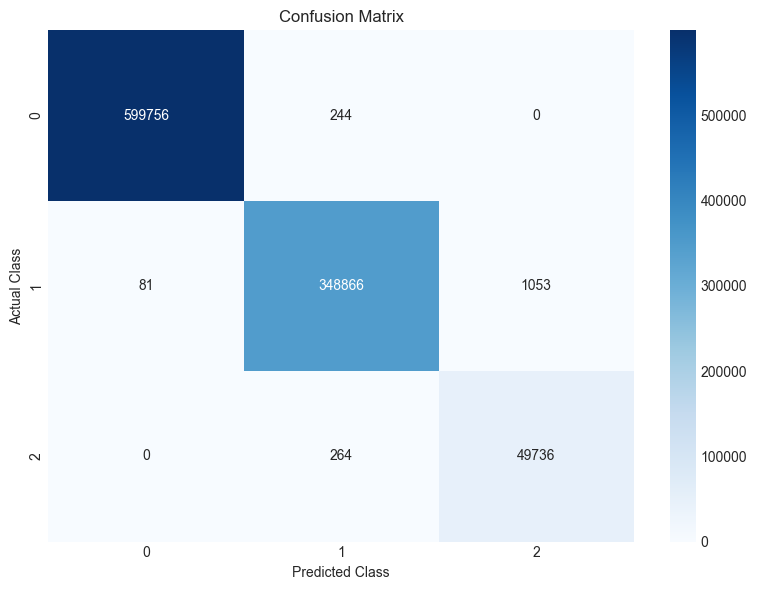


[3/3] Saving predictions to Delta Lake...
  Saved to: s3a://bigdata-ecommerce/models/predictions/customer_segments_output
  Ready for production serving!

  Batch predictions pipeline complete


In [39]:
# PREDICTIONS RF

print("=" * 80)
print("BATCH PREDICTIONS PIPELINE - RF CLASSIFIER")
print("=" * 80)

# Load RF model
print("\nLoading RF model...")

rf_path = f"{best_rf_run['model_path']}"

try:
    loaded_rf_model = RandomForestClassificationModel.load(rf_path)
    print(f"  ALS model loaded successfully")
    print(f"  Type: {type(loaded_rf_model)}")  
    
except Exception as e:
    print(f"  Error loading ALS model: {e}")

print("\n  Model loading demonstration complete")

print("\nLoading customer features...")
try:
    customers_full = spark.read.format("delta").load(DATA_PATHS['customer_features'])
    customers_count = customers_full.count()
    print(f"  Loaded {customers_count:,} customer records")
    print(f"  Schema: {customers_full.columns}")
    customers_full.printSchema()
    
except Exception as e:
    print(f"  Error loading customers: {e}")
    raise

# Use full customer dataset with features
print("\n[1/3] Transform and predict for all customers")
start_time = time.time()

# Define feature columns
numeric_features = ['recency', 'frequency', 'monetary', 'avg_transaction', 'unique_products', 'age']

# Fit indexers on full data
string_indexer_prod = StringIndexer(
    inputCol="region",
    outputCol="region_indexed",
    handleInvalid="keep"
)
string_indexer_model_prod = string_indexer_prod.fit(customers_full)

label_indexer_prod = StringIndexer(
    inputCol="customer_segment",
    outputCol="label",
    handleInvalid="keep"
)
label_indexer_model_prod = label_indexer_prod.fit(customers_full)

# Assembler (same as development)
assembler_prod = VectorAssembler(
    inputCols=numeric_features + ["region_indexed"],
    outputCol="features",
    handleInvalid="keep"
)

# Transform full dataset
customers_full_indexed = string_indexer_model_prod.transform(customers_full)
customers_full_indexed = label_indexer_model_prod.transform(customers_full_indexed)
customers_full_transformed = assembler_prod.transform(customers_full_indexed)

# Predict
all_predictions = loaded_rf_model.transform(customers_full_transformed)
total_customers = all_predictions.count()

pred_time = time.time() - start_time

print(f"  Classified {total_customers:,} customers in {pred_time:.1f}s")
print(f"  Throughput: {total_customers/pred_time:.0f} customers/second")

# Prediction distribution
print("\n[2/3] Prediction distribution:")
all_predictions.show(5)
all_predictions.groupBy("prediction").count().orderBy("prediction").show()


# Confusion Matrix
print("\n  Confusion Matrix")

# Convert to RDD for confusion matrix
predictions_and_labels = all_predictions.select("prediction", "label").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictions_and_labels)

# Get confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=True)
plt.title(f'Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.tight_layout()
plt.savefig(GRAPH_DIR / '04_rf_confusion_matrix.png', dpi=300, bbox_inches='tight')
print("  Saved PNG: 04_rf_confusion_matrix.png")
plt.show()

# Save to Delta Lake
print("\n[3/3] Saving predictions to Delta Lake...")
preds_output_path = f"{MODELS_PATHS['pred']}/customer_segments_output"

try:
    all_predictions.select("customer_id", "prediction", "probability").write.format("delta").mode("overwrite").save(preds_output_path)
    print(f"  Saved to: {preds_output_path}")
    print("  Ready for production serving!")
except Exception as e:
    print(f"  Could not save to Delta Lake: {e}")
    print("  In production, configure proper MinIO/S3 access")

print("\n  Batch predictions pipeline complete")
spark.stop()